<h2><u>EXERCISE 4</u></h2>

In [1]:
import numpy as np
from scipy import sparse
import csv
import random

user_indices = [] # the indices of each user id. Each list position refers to the index of the user in the corresponding line of the file
business_indices = [] # the indices of each business id. Each list position refers to the index of the business in the corresponding line of the file
ratings = [] # the ratings of each line
user_map = {} # a dictionary which matches each user id with its index
business_map = {} # a dictionary which matches each business id with its index

business_rated_by = {} # a dictionary with keys being business indices and values being the list of indices of the users that rated the business
user_has_reviewed = {} # a dictionary with keys being user indices and values being the list of indices of the business that the user has reviewed

with open('pruned_data.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)

    user_index = -1
    business_index = -1
    previously_parsed_user = '' # id
    previously_parsed_business = '' # id
    businessAlreadyRecorded = False # business id's don't appear in order, which means we need to remember if the business has already been indexed

    for line in csv_reader:
        if(line[0] != previously_parsed_user): # if the next user id is different, then the previous id won't appear again due to the file structure
            user_index += 1
            previously_parsed_user = line[0]
            user_has_reviewed[user_index] = []
        
        user_indices.append(user_index)   
        user_map[line[0]] = user_index    

        for business in business_map.keys(): # check if we have already recorder the business id of this line
            if(line[1] == business):
                businessAlreadyRecorded = True
                break

        if(not businessAlreadyRecorded): # then we need to assign a new index and record it
            business_index += 1
            business_map[line[1]] = business_index
            business_rated_by[business_index] = []
            
        business_rated_by[business_map[line[1]]].append(user_index)
        user_has_reviewed[user_index].append(business_map[line[1]])

        business_indices.append(business_map[line[1]]) 
        businessAlreadyRecorded = False # back to false for the next line iteration

        ratings.append(float(line[2]))


user_indicesNP = np.array(user_indices)
business_indicesNP = np.array(business_indices)
ratingsNP = np.array(ratings)

In [2]:
R = sparse.csr_matrix((ratingsNP, (user_indicesNP, business_indicesNP)))


numberOfRatingsToBeRemoved = int(0.05 * len(ratings))

# we need to keep the indices of the business/user ratings that we removed
removedUserPositions = []
removedBusinessPositions = []
users_that_reviewed_the_same_business = []
removedRatings = np.zeros(numberOfRatingsToBeRemoved)


for i in range(numberOfRatingsToBeRemoved):
    pos = random.randint(0, len(ratings) - 1)

    while(ratings[pos] is None): # we need to check that the random rating hasn't already been removed
        pos = random.randint(0, len(ratings) - 1)

    removedRatings[i] = ratings[pos]
    removedUserPositions.append(user_indices[pos])
    removedBusinessPositions.append(business_indices[pos])
    ratings[pos] = None
    
    
for i in range(numberOfRatingsToBeRemoved): # actual removal of the ratings from the sparse matrix
    R[removedUserPositions[i], removedBusinessPositions[i]] = 0
        

<h3>TASK 1</h3>

In [16]:
import ijson # library which will be used to read the review dataset line by line, without loading it in memory
from datetime import datetime

user_ratings_with_dates = {} # dictionary with user id's as keys and a dict of (business_id : date) pairs as values

with open('yelp_academic_dataset_review.json ', 'r', encoding = "utf8") as f1:   
    parser = ijson.parse(f1, multiple_values = True) 

    business_id = ''  
    user_id = ''
    date_str = ''
    
    for prefix, event, value in parser:
        if(prefix == "user_id"):
            user_id = value
        if(prefix == "business_id"):
            business_id = value
        if(prefix == "date"):
            date_str = value
            if(user_id in user_map.keys() and business_id in business_map.keys()): # we only need the dates of ratings that refer to our dataset
                if(R[user_map[user_id], business_map[business_id]] != 0): # we need to check that the rating is not of the 5% that has been removed (we shouldn't use this info for training)
                    if(user_id in user_ratings_with_dates.keys()):
                        user_ratings_with_dates[user_id][business_id] = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
                    else:
                        user_ratings_with_dates[user_id] = {business_id : datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")}
            business_id = ''  
            user_id = ''
            date_str = ''

In [22]:
print(user_ratings_with_dates.keys())

dict_keys(['TZQSUDDcA4ek5gBd6BzcjA', 'AdMCAKmNDIaubYPxnjTq1g', '1kNsEAhGU8d8xugMuXJGFA', 'Kl6jNDAE7PG_VVQafIptxQ', 'is1nHZ4oBqqmBm_mfVyhoQ', 'JnPIjvC0cmooNDfsa9BmXg', 'pMefTWo6gMdx8WhYSA2u3w', 'BwwqlPVsJk1dbUyNwCWB7Q', '4dIxMP5--LX1X0i3s3PIAA', '0aHFybE0id9DD97QzAfNDQ', 'Fw8Lj7q7DqTh-m3hGtXoiw', '_xEw7D-qZ4DL2rOD5ZWPvg', 'VrMaL32wWNed_DjOcsO3Ng', '9rMg4ePrSLCqvzebAlUStQ', 'tIFWjDotktTv8vbs5gFQ-A', 'ir7fsp088Gux3G1jrLT72w', 'LmWO_u9v7e1vMJlNykjUoA', 'CQ67NJigSe5-uBDX3b_CUw', '74goFJSWzAwmk69XfPqEag', 'OtqdOQ2cwOsO5xwTeBxlsw', 'LRARPyzzf7FpH7lJXJgH2w', 'xCby-gCFW8aLmXbMhMms2g', '8qY0rSk-AUtCAl8th4ru2A', 'xVV86BToDOQGxE1gt9MMvg', 'GJj9os-AgcBEExrxDRZRtQ', 'M1mSvucWF3V1h0L98okb9g', 'oerw70Uc1dQl8t-86fOUsg', 'yruTLOggpeMXoHu_O_Zd3A', 'nXehm6zt294ZswIgh5LpbA', 'CxDOIDnH8gp9KXzpBHJYXw', 'CyPLi2BMi3N2z-E7Qpp26A', 'l1VoG-0-bDF-us7xbWxfeg', 'rR3KgAwuJxk9Roz4J5_jtg', 'vMrnL8HA0OvnME8PC0Dg1A', 'jnC1CcEF9KjCs2gw82SfSQ', 'KnkiyXZDt8hVdq_kw1iWuw', '0l3x4EgoWVYdla3CPpAKag', 'Qc69D3sD1zzGLpjSkSoSew', '

I print the elements for one user so that it becomes apparent that the elements are not sorted by date.

In [23]:
print(user_ratings_with_dates['TZQSUDDcA4ek5gBd6BzcjA'])

{'qUWqjjjfpB2-4P3He5rsKw': datetime.datetime(2017, 6, 6, 19, 4, 10), '6n_MDeYxU1ihB38be9TkVA': datetime.datetime(2014, 1, 8, 0, 1, 18), 'jo4KmAqlZ7vxjHIP7IIkAw': datetime.datetime(2013, 4, 24, 18, 15, 41), 'dsAcgF6qtZy2m6d_yWCrGQ': datetime.datetime(2019, 1, 17, 20, 14, 10), 'siaRCT2-PkyeXUVKrywcTg': datetime.datetime(2019, 1, 21, 0, 45, 3), 'SGP1jf6k7spXkgwBlhiUVw': datetime.datetime(2013, 10, 23, 4, 24, 26), 'orrhJxM6V1USwccG7MlxmA': datetime.datetime(2016, 6, 29, 15, 7, 20), 'fJ-2acaqvWOsujUTAJB-ew': datetime.datetime(2013, 7, 27, 16, 22, 25), '272a60ze8sADYRR6GyJ3GA': datetime.datetime(2017, 12, 28, 19, 43, 3), '47wBHgBwQ8_70sjmXow_1g': datetime.datetime(2019, 4, 10, 19, 9, 41), 'Nq0UHjD_cKW9UbIJplQf_g': datetime.datetime(2017, 5, 1, 21, 12, 32), '6eRSdODyj9GS0w6zlhrWkg': datetime.datetime(2017, 12, 29, 18, 46, 50), '9KBd2YPnRxaNjZz23TUd6A': datetime.datetime(2013, 7, 12, 20, 30, 22), 'hMmmvyRtweNBSPMbMCpnow': datetime.datetime(2011, 6, 8, 4, 13, 26), 'ruR-mrEaNbFJGnM-WCbcgg': date

I sort in ascending order of dates.

In [24]:
for user_id in user_ratings_with_dates:
    user_ratings_with_dates[user_id] = dict(sorted(user_ratings_with_dates[user_id].items(), key=lambda item: item[1])) # sorting each dict by value (date)

I print the elements of the same user and it becomes apparent that they have been sorted.

In [28]:
print(user_ratings_with_dates['TZQSUDDcA4ek5gBd6BzcjA'])

{'qhagbvK-Pv4cGGghJ7gXBA': datetime.datetime(2011, 5, 24, 3, 47, 11), 'qaNt4vtVdge_S68DVjw5Jg': datetime.datetime(2011, 5, 27, 16, 22, 50), '_F1_05YYlvePzomZ_NFijA': datetime.datetime(2011, 5, 27, 20, 18, 5), 'grZEbAsZwWA3yJMwDRl0Nw': datetime.datetime(2011, 6, 7, 17, 59, 7), 'hMmmvyRtweNBSPMbMCpnow': datetime.datetime(2011, 6, 8, 4, 13, 26), 'vh1tPEaPioD78QmoqnWXpw': datetime.datetime(2013, 3, 14, 20, 28, 3), 'N93EYZy9R0sdlEvubu94ig': datetime.datetime(2013, 3, 15, 1, 55, 19), 'oWTn2IzrprsRkPfULtjZtQ': datetime.datetime(2013, 3, 16, 3, 21, 12), 'jo4KmAqlZ7vxjHIP7IIkAw': datetime.datetime(2013, 4, 24, 18, 15, 41), 'iAxsnFs3qq0Qx1EJ1S9SoQ': datetime.datetime(2013, 7, 1, 17, 58, 45), '9KBd2YPnRxaNjZz23TUd6A': datetime.datetime(2013, 7, 12, 20, 30, 22), 'fJ-2acaqvWOsujUTAJB-ew': datetime.datetime(2013, 7, 27, 16, 22, 25), 'VbmvagpfBfgvjOJb65BWVA': datetime.datetime(2013, 7, 31, 18, 53, 4), 'SGP1jf6k7spXkgwBlhiUVw': datetime.datetime(2013, 10, 23, 4, 24, 26), '8I5U8OQ06nSxX2y4PPOWzQ': date

I create the vectors with the business id's that each user rated.

In [29]:
user_ratings_corpus = []

for user_id in user_ratings_with_dates:
    business_id_list = list(user_ratings_with_dates[user_id].keys())
    user_ratings_corpus.append(business_id_list)

Using the skipgram model.

In [32]:
import gensim 
from gensim.models import Word2Vec

embedding_size = 100 # professor asked us to keep this costant
skipgram_model = gensim.models.Word2Vec(user_ratings_corpus, min_count = 1,size = embedding_size, window = 50, sg = 1) 

In [36]:
print(skipgram_model.wv['qhagbvK-Pv4cGGghJ7gXBA']) # checking a business vector

[-0.28388926 -0.13608144  0.25554162 -0.17722507 -0.28525096 -0.12735732
 -0.15698825  0.031908   -0.09911083 -0.13024724  0.23745635 -0.07906898
  0.10367188 -0.09898813  0.00920583  0.09770107  0.17983073  0.33576998
 -0.15366925  0.11059854  0.10571233 -0.3533288  -0.18851049 -0.12639529
  0.37643805  0.0880582  -0.33373088 -0.09415071  0.15354358  0.04568506
  0.08407635 -0.02855822  0.22831282 -0.16932578 -0.06062195 -0.29341403
  0.03229626  0.14807437  0.06395674 -0.19780397  0.02443207 -0.27543354
 -0.00995283 -0.19610004  0.1340424   0.22831605 -0.05154415 -0.24017304
 -0.0361868  -0.05846301  0.09143743 -0.06294347  0.13775112 -0.08189963
 -0.06259692  0.01161787  0.04831454 -0.11080864 -0.12144065 -0.20279959
  0.02287104 -0.24358875 -0.09285902  0.00437024  0.09203961  0.15983728
 -0.28957593 -0.18199143  0.02963918 -0.27237582 -0.22468042 -0.0262846
 -0.15578051  0.00224208  0.11736062  0.05891953 -0.16338429  0.46701723
  0.11735408  0.23784655  0.2916729  -0.16787632  0.

<p style="font-size:110%;">We create an array where each line is the skipgram vector of the business that corresponds to the index of the line and the matrix will keep all such vectors of the dataset businesses. We then use this matrix in order to compute cosine similarities between businesses.</p>

In [38]:
print(max(business_rated_by.keys())) 

4091


<p style="font-size:110%;"> I printed the businesses' maximum index, because this number shows us how many different businesses there are in the dataset and how many rows the business2vecMatrix bellow will have. </p>

In [41]:
business2vecMatrix = np.zeros([4092, embedding_size])

for business_id in skipgram_model.wv.vocab:
    business_index = business_map[business_id]
    business2vecMatrix[business_index] = skipgram_model.wv[business_id]
    
print(business2vecMatrix)

[[-0.10832702 -0.07962665  0.19106235 ... -0.15045333 -0.30824712
  -0.14211167]
 [-0.39472881 -0.1860818   0.13982052 ...  0.19342531 -0.04756536
   0.24775246]
 [-0.41219074 -0.16452834  0.1194071  ...  0.0774608  -0.27359393
   0.13252665]
 ...
 [-0.12091702 -0.16975413  0.17462774 ... -0.13946164 -0.19106311
   0.04109396]
 [-0.06062296 -0.32008457  0.52115971 ... -0.13792765  0.09591702
  -0.20390105]
 [-0.02885745  0.04926136  0.37789881 ... -0.10153557  0.09408516
  -0.24389821]]


<p style="font-size:110%;"> Now that I've shown the way we come up with the necessary matrix, I must paraeterise the ICF function I had created in the previous set of exercises in order to also have a window size as parameter. Using the parameters, the function will need to be creating a skipgram model, a business2vecMatrix and through that matrix compute the cosine similarities between the businesses. The rest of the steps remain the same. </p>

In [48]:
from sklearn import metrics

# Item-Based Collaborative Filtering (ICF), using skipgram method

def ICF_using_skipgram(k, window_size): 
    
    skipgram_model_for_ICF = gensim.models.Word2Vec(user_ratings_corpus, min_count = 1, size = embedding_size, window = window_size, sg = 1) 
    business2vecMatrixICF = np.zeros([4092, embedding_size])

    for business_id in skipgram_model_for_ICF.wv.vocab:
        business_index = business_map[business_id]
        business2vecMatrixICF[business_index] = skipgram_model_for_ICF.wv[business_id]
    
    similarity_matrix = metrics.pairwise.cosine_similarity(business2vecMatrixICF, Y=None, dense_output=True)
    predicted_missing_ratings = []
    
    b_pos = -1

    for u in removedUserPositions:
        b_pos += 1
        b = removedBusinessPositions[b_pos]

        reviewed_businesses = user_has_reviewed[u]

        if(b in reviewed_businesses):
            reviewed_businesses.remove(b)

        business_similarities = []
        business_dict = {}

        for business in reviewed_businesses:
            similarity = similarity_matrix[business, b]
            business_similarities.append(similarity)
            business_dict[similarity] = business

        k_most_similar_similarities = []
        
        if(len(business_similarities) > k):
            business_similarities = np.array(business_similarities)
            k_most_similar_similarities = np.partition(business_similarities, -k)[-k:]
        else:
            k_most_similar_similarities = np.array(business_similarities)
            
        k_most_similar_businesses = []
        k_most_similar_ratings = []

        for similarity in k_most_similar_similarities:
            k_most_similar_businesses.append(business_dict[similarity])

        for business in k_most_similar_businesses:
            k_most_similar_ratings.append(R[u,business])    

        k_most_similar_ratings = np.array(k_most_similar_ratings)

        predicted_rating = np.inner(k_most_similar_similarities, k_most_similar_ratings) / np.sum(k_most_similar_similarities)
        predicted_missing_ratings.append(predicted_rating)
        
    return predicted_missing_ratings

 

In [49]:
predictions = ICF_using_skipgram(5, 100) # testing the method and printing its results

for i in range(len(predictions)):
    print("Removed rating: ", removedRatings[i], " Prediction: ", predictions[i] )

Removed rating:  2.0  Prediction:  4.04364488394029
Removed rating:  2.0  Prediction:  3.995126293467774
Removed rating:  4.0  Prediction:  4.142818616391799
Removed rating:  3.0  Prediction:  3.9748500471807473
Removed rating:  3.0  Prediction:  4.185123713125701
Removed rating:  1.0  Prediction:  3.7768779345066164
Removed rating:  4.0  Prediction:  4.803061184040513
Removed rating:  4.0  Prediction:  3.6011320121998036
Removed rating:  4.0  Prediction:  3.4032472548309767
Removed rating:  4.0  Prediction:  3.5404482010253364
Removed rating:  3.0  Prediction:  2.993893931786734
Removed rating:  4.0  Prediction:  4.196513935319077
Removed rating:  3.0  Prediction:  3.997532315939729
Removed rating:  2.0  Prediction:  4.183344216815672
Removed rating:  5.0  Prediction:  3.123507896007218
Removed rating:  4.0  Prediction:  4.214382128937149
Removed rating:  3.0  Prediction:  3.8052422862684994
Removed rating:  1.0  Prediction:  2.374554144278163
Removed rating:  5.0  Prediction:  3.7892

Removed rating:  5.0  Prediction:  3.358010414676537
Removed rating:  4.0  Prediction:  4.193615766088777
Removed rating:  2.0  Prediction:  3.6024571746469434
Removed rating:  5.0  Prediction:  3.700891143898603
Removed rating:  2.0  Prediction:  3.422775499332359
Removed rating:  3.0  Prediction:  2.986270488584202
Removed rating:  4.0  Prediction:  3.191625039364427
Removed rating:  3.0  Prediction:  3.7824077462984556
Removed rating:  4.0  Prediction:  3.022709461151339
Removed rating:  4.0  Prediction:  4.0
Removed rating:  2.0  Prediction:  3.5897875866969375
Removed rating:  5.0  Prediction:  4.198849425870852
Removed rating:  4.0  Prediction:  3.8082561501158163
Removed rating:  4.0  Prediction:  4.633131300367297
Removed rating:  3.0  Prediction:  4.400782633328169
Removed rating:  4.0  Prediction:  3.7559328385663324
Removed rating:  4.0  Prediction:  4.3887037462326495
Removed rating:  4.0  Prediction:  3.9763005981298623
Removed rating:  4.0  Prediction:  4.391670337828285


Removed rating:  4.0  Prediction:  3.8135854438662196
Removed rating:  4.0  Prediction:  3.9705873219075265
Removed rating:  4.0  Prediction:  3.7796481454602917
Removed rating:  1.0  Prediction:  2.610723471268339
Removed rating:  2.0  Prediction:  4.392826602389958
Removed rating:  3.0  Prediction:  3.0019274021383726
Removed rating:  4.0  Prediction:  4.0077196400638995
Removed rating:  1.0  Prediction:  3.2067044739836397
Removed rating:  3.0  Prediction:  3.078765956610129
Removed rating:  4.0  Prediction:  3.962369180673072
Removed rating:  4.0  Prediction:  3.798037363682884
Removed rating:  4.0  Prediction:  3.2040193221262183
Removed rating:  3.0  Prediction:  4.199500091425656
Removed rating:  4.0  Prediction:  3.6045108910750563
Removed rating:  5.0  Prediction:  3.3745822948758923
Removed rating:  4.0  Prediction:  4.397633466060645
Removed rating:  4.0  Prediction:  3.783452385207324
Removed rating:  3.0  Prediction:  3.7808609405638873
Removed rating:  3.0  Prediction:  3

Removed rating:  5.0  Prediction:  4.0948176919704125
Removed rating:  3.0  Prediction:  3.191709785471631
Removed rating:  4.0  Prediction:  3.0012014139081558
Removed rating:  3.0  Prediction:  3.3195681732839573
Removed rating:  2.0  Prediction:  3.839272530750067
Removed rating:  4.0  Prediction:  3.183250722336599
Removed rating:  1.0  Prediction:  3.393598941492461
Removed rating:  3.0  Prediction:  4.532037735061625
Removed rating:  5.0  Prediction:  4.602757357173195
Removed rating:  4.0  Prediction:  3.0140719855451636
Removed rating:  5.0  Prediction:  2.784299260326616
Removed rating:  4.0  Prediction:  3.8077338320823695
Removed rating:  4.0  Prediction:  3.1789560397532615
Removed rating:  3.0  Prediction:  4.604687372361123
Removed rating:  4.0  Prediction:  3.6482820523996176
Removed rating:  4.0  Prediction:  4.222822111758538
Removed rating:  5.0  Prediction:  3.476338705930233
Removed rating:  5.0  Prediction:  4.198118819709681
Removed rating:  3.0  Prediction:  2.62

Removed rating:  4.0  Prediction:  4.422261188195653
Removed rating:  5.0  Prediction:  3.6403898134216455
Removed rating:  1.0  Prediction:  5.0
Removed rating:  5.0  Prediction:  3.805457443350339
Removed rating:  5.0  Prediction:  3.393231234996285
Removed rating:  4.0  Prediction:  3.6134828810752233
Removed rating:  3.0  Prediction:  2.2404535063409274
Removed rating:  4.0  Prediction:  3.396380961795312
Removed rating:  3.0  Prediction:  4.007485861926846
Removed rating:  5.0  Prediction:  3.8029539595897077
Removed rating:  4.0  Prediction:  3.4101374939787847
Removed rating:  4.0  Prediction:  3.396445497039715
Removed rating:  5.0  Prediction:  3.9832278862956914
Removed rating:  3.0  Prediction:  3.614890412453339
Removed rating:  5.0  Prediction:  4.135343534885932
Removed rating:  3.0  Prediction:  3.212269339339782
Removed rating:  4.0  Prediction:  2.7864465699270466
Removed rating:  4.0  Prediction:  3.3896469020812092
Removed rating:  3.0  Prediction:  3.593735042537159

Removed rating:  4.0  Prediction:  4.178506454325218
Removed rating:  4.0  Prediction:  3.9999999999999996
Removed rating:  3.0  Prediction:  3.5829404419026023
Removed rating:  5.0  Prediction:  3.790356532671159
Removed rating:  3.0  Prediction:  4.001482750391027
Removed rating:  5.0  Prediction:  4.411289461277638
Removed rating:  4.0  Prediction:  3.36797779469355
Removed rating:  2.0  Prediction:  3.8685370852533256
Removed rating:  4.0  Prediction:  3.8356804293897033
Removed rating:  2.0  Prediction:  2.4329616596288863
Removed rating:  3.0  Prediction:  3.0056042981144655
Removed rating:  3.0  Prediction:  4.004196419805664
Removed rating:  5.0  Prediction:  3.566131059903183
Removed rating:  3.0  Prediction:  2.790349283325749
Removed rating:  4.0  Prediction:  3.187420108891225
Removed rating:  2.0  Prediction:  3.033439372618548
Removed rating:  4.0  Prediction:  3.390389648846228
Removed rating:  5.0  Prediction:  4.999999999999999
Removed rating:  3.0  Prediction:  3.9999

Removed rating:  4.0  Prediction:  3.8049666754595037
Removed rating:  4.0  Prediction:  3.0017697508493044
Removed rating:  4.0  Prediction:  3.578585200257233
Removed rating:  4.0  Prediction:  4.193827366534122
Removed rating:  4.0  Prediction:  3.793936822455545
Removed rating:  5.0  Prediction:  4.200243535189324
Removed rating:  4.0  Prediction:  3.0098210679859374
Removed rating:  4.0  Prediction:  4.360154883109333
Removed rating:  1.0  Prediction:  1.0
Removed rating:  4.0  Prediction:  3.8149969200930505
Removed rating:  2.0  Prediction:  3.8116993596992463
Removed rating:  4.0  Prediction:  3.780709143038894
Removed rating:  4.0  Prediction:  3.5828635630256884
Removed rating:  4.0  Prediction:  3.1925249983599486
Removed rating:  4.0  Prediction:  2.780047913920768
Removed rating:  4.0  Prediction:  2.7698981680108345
Removed rating:  4.0  Prediction:  5.0
Removed rating:  4.0  Prediction:  3.788766606148367
Removed rating:  5.0  Prediction:  5.0
Removed rating:  3.0  Predi

Removed rating:  1.0  Prediction:  4.638850705092914
Removed rating:  5.0  Prediction:  4.172291760103371
Removed rating:  4.0  Prediction:  4.20337753921603
Removed rating:  4.0  Prediction:  3.3253147222473767
Removed rating:  2.0  Prediction:  3.6594925155147418
Removed rating:  4.0  Prediction:  3.330014332343523
Removed rating:  4.0  Prediction:  4.208149283190098
Removed rating:  4.0  Prediction:  3.051148175158872
Removed rating:  4.0  Prediction:  4.229572366739932
Removed rating:  3.0  Prediction:  3.002420049884792
Removed rating:  5.0  Prediction:  4.35615765640238
Removed rating:  4.0  Prediction:  4.164133771960319
Removed rating:  4.0  Prediction:  2.769843141082563
Removed rating:  5.0  Prediction:  3.6370499968445755
Removed rating:  4.0  Prediction:  3.416852982059052
Removed rating:  2.0  Prediction:  3.2056906921090498
Removed rating:  5.0  Prediction:  4.399276550336665
Removed rating:  4.0  Prediction:  3.1958443592043766
Removed rating:  4.0  Prediction:  3.481049

Removed rating:  4.0  Prediction:  3.7631506955374014
Removed rating:  2.0  Prediction:  2.7996405132861772
Removed rating:  5.0  Prediction:  5.000000000000001
Removed rating:  3.0  Prediction:  3.404184614235602
Removed rating:  5.0  Prediction:  4.804204916725699
Removed rating:  4.0  Prediction:  3.98424434458663
Removed rating:  4.0  Prediction:  3.440175660207752
Removed rating:  5.0  Prediction:  4.431501544981914
Removed rating:  5.0  Prediction:  3.3769492249207658
Removed rating:  2.0  Prediction:  3.2041205211083907
Removed rating:  4.0  Prediction:  3.16811504807967
Removed rating:  3.0  Prediction:  3.0102784540559457
Removed rating:  4.0  Prediction:  4.5986189700788165
Removed rating:  4.0  Prediction:  4.780087900085276
Removed rating:  3.0  Prediction:  3.434761709380615
Removed rating:  3.0  Prediction:  3.9938433125722064
Removed rating:  3.0  Prediction:  3.62774487757113
Removed rating:  4.0  Prediction:  4.011777625393063
Removed rating:  3.0  Prediction:  3.43309

Removed rating:  3.0  Prediction:  3.203396041703494
Removed rating:  5.0  Prediction:  3.385407597306131
Removed rating:  5.0  Prediction:  3.9533133402527225
Removed rating:  3.0  Prediction:  4.377959675797982
Removed rating:  2.0  Prediction:  3.6552731843676587
Removed rating:  3.0  Prediction:  3.179327970331521
Removed rating:  4.0  Prediction:  3.7945560327096395
Removed rating:  3.0  Prediction:  3.3928733087406617
Removed rating:  1.0  Prediction:  3.5888833118214185
Removed rating:  2.0  Prediction:  4.00564289386467
Removed rating:  3.0  Prediction:  3.198024312797068
Removed rating:  4.0  Prediction:  4.0
Removed rating:  3.0  Prediction:  4.591672002252522
Removed rating:  5.0  Prediction:  4.0
Removed rating:  4.0  Prediction:  4.130232869648788
Removed rating:  2.0  Prediction:  3.7963629975880524
Removed rating:  4.0  Prediction:  3.2140934296240773
Removed rating:  4.0  Prediction:  3.995720192169987
Removed rating:  4.0  Prediction:  4.402674823521363
Removed rating:

Removed rating:  5.0  Prediction:  3.514893510199077
Removed rating:  5.0  Prediction:  3.1532893786327847
Removed rating:  4.0  Prediction:  4.026772126852507
Removed rating:  5.0  Prediction:  3.3952270301283423
Removed rating:  5.0  Prediction:  3.402978045741685
Removed rating:  1.0  Prediction:  3.2011644683215477
Removed rating:  3.0  Prediction:  3.59888827628149
Removed rating:  5.0  Prediction:  3.978273579369359
Removed rating:  5.0  Prediction:  3.404646579079938
Removed rating:  1.0  Prediction:  2.3780264140046286
Removed rating:  5.0  Prediction:  3.827676105734274
Removed rating:  5.0  Prediction:  3.061426179993924
Removed rating:  5.0  Prediction:  3.7826397978145647
Removed rating:  4.0  Prediction:  3.5967974898053168
Removed rating:  4.0  Prediction:  3.8165514194405987
Removed rating:  3.0  Prediction:  3.401400015118678
Removed rating:  3.0  Prediction:  3.613767004193402
Removed rating:  5.0  Prediction:  3.4009113906515287
Removed rating:  4.0  Prediction:  3.58

Removed rating:  4.0  Prediction:  3.457808540647204
Removed rating:  1.0  Prediction:  3.8857341629423954
Removed rating:  5.0  Prediction:  4.217393402407058
Removed rating:  3.0  Prediction:  4.408482576195901
Removed rating:  4.0  Prediction:  4.403308681276736
Removed rating:  4.0  Prediction:  2.8193430234654246
Removed rating:  3.0  Prediction:  3.98710675541941
Removed rating:  5.0  Prediction:  4.381215692593327
Removed rating:  4.0  Prediction:  3.207192514219679
Removed rating:  2.0  Prediction:  3.1968217002493833
Removed rating:  5.0  Prediction:  4.24607166078243
Removed rating:  4.0  Prediction:  5.0
Removed rating:  5.0  Prediction:  4.191294029378533
Removed rating:  4.0  Prediction:  3.199396452531435
Removed rating:  1.0  Prediction:  2.1930094489871554
Removed rating:  3.0  Prediction:  3.3967063301302725
Removed rating:  3.0  Prediction:  3.21633994464108
Removed rating:  2.0  Prediction:  3.792673456346567
Removed rating:  3.0  Prediction:  3.8010841450487924
Remo

Removed rating:  4.0  Prediction:  3.979240994734302
Removed rating:  2.0  Prediction:  4.585563821707792
Removed rating:  1.0  Prediction:  3.8255800180052058
Removed rating:  3.0  Prediction:  2.8318524497497153
Removed rating:  4.0  Prediction:  3.0074562069634165
Removed rating:  1.0  Prediction:  3.155155590710513
Removed rating:  5.0  Prediction:  4.200955714822052
Removed rating:  4.0  Prediction:  2.57916363718419
Removed rating:  4.0  Prediction:  3.381792107093045
Removed rating:  5.0  Prediction:  2.9955344137994024
Removed rating:  3.0  Prediction:  3.191530075577468
Removed rating:  2.0  Prediction:  3.4067238937129933
Removed rating:  3.0  Prediction:  3.3988867450423808
Removed rating:  4.0  Prediction:  4.0
Removed rating:  4.0  Prediction:  4.3956144125250205
Removed rating:  3.0  Prediction:  2.3371478359392
Removed rating:  3.0  Prediction:  3.76266303997027
Removed rating:  4.0  Prediction:  4.4251011817974355
Removed rating:  1.0  Prediction:  4.176532523247927
Rem

Removed rating:  3.0  Prediction:  3.61700773588144
Removed rating:  2.0  Prediction:  2.624493949836376
Removed rating:  4.0  Prediction:  3.0082417466019353
Removed rating:  5.0  Prediction:  3.4059704196801657
Removed rating:  3.0  Prediction:  3.3956735100348983
Removed rating:  4.0  Prediction:  3.7974680453386602
Removed rating:  5.0  Prediction:  4.4351365768658235
Removed rating:  5.0  Prediction:  4.803697530334623
Removed rating:  5.0  Prediction:  4.607615892054523
Removed rating:  4.0  Prediction:  3.5970819217245777
Removed rating:  4.0  Prediction:  3.8160726773022313
Removed rating:  2.0  Prediction:  2.197370014987692
Removed rating:  3.0  Prediction:  3.576152506403969
Removed rating:  2.0  Prediction:  3.18750643788556
Removed rating:  4.0  Prediction:  3.6060934889664185
Removed rating:  4.0  Prediction:  3.5998484660341457
Removed rating:  3.0  Prediction:  3.3852784279537356
Removed rating:  2.0  Prediction:  2.3920948453954667
Removed rating:  5.0  Prediction:  3.

Removed rating:  4.0  Prediction:  4.189556287470875
Removed rating:  4.0  Prediction:  2.8283351746792245
Removed rating:  4.0  Prediction:  4.5965354755829
Removed rating:  4.0  Prediction:  3.023589313583632
Removed rating:  4.0  Prediction:  2.831601445539783
Removed rating:  5.0  Prediction:  3.608767408903357
Removed rating:  3.0  Prediction:  3.5813053177214664
Removed rating:  4.0  Prediction:  2.6110020525775597
Removed rating:  4.0  Prediction:  3.030124302199323
Removed rating:  2.0  Prediction:  3.77000191840372
Removed rating:  3.0  Prediction:  3.3784854713309573
Removed rating:  4.0  Prediction:  4.022467838800075
Removed rating:  4.0  Prediction:  3.6105748312567223
Removed rating:  5.0  Prediction:  4.224588798404266
Removed rating:  4.0  Prediction:  4.241449556656671
Removed rating:  4.0  Prediction:  4.395246214958712
Removed rating:  4.0  Prediction:  3.610825527103359
Removed rating:  5.0  Prediction:  4.8002586010142165
Removed rating:  5.0  Prediction:  4.145543

Removed rating:  3.0  Prediction:  2.9708813711418416
Removed rating:  5.0  Prediction:  4.4288952157367065
Removed rating:  4.0  Prediction:  3.3908841023794327
Removed rating:  4.0  Prediction:  3.9456039072768165
Removed rating:  5.0  Prediction:  3.978495996441736
Removed rating:  4.0  Prediction:  3.0036567586293383
Removed rating:  1.0  Prediction:  4.999999999999999
Removed rating:  5.0  Prediction:  3.606277143272293
Removed rating:  3.0  Prediction:  3.4042040301732297
Removed rating:  5.0  Prediction:  4.818692813121016
Removed rating:  4.0  Prediction:  3.1968238382064267
Removed rating:  5.0  Prediction:  3.8001656857644592
Removed rating:  4.0  Prediction:  3.3748465641541148
Removed rating:  2.0  Prediction:  2.9210998129128996
Removed rating:  5.0  Prediction:  4.0
Removed rating:  3.0  Prediction:  4.206643053123312
Removed rating:  3.0  Prediction:  3.006707175021125
Removed rating:  5.0  Prediction:  4.000000000000001
Removed rating:  5.0  Prediction:  3.7611329613415

Removed rating:  5.0  Prediction:  4.632668491315021
Removed rating:  5.0  Prediction:  3.4172238300944184
Removed rating:  2.0  Prediction:  2.60805575894083
Removed rating:  5.0  Prediction:  4.411562124486409
Removed rating:  3.0  Prediction:  3.169914701004981
Removed rating:  5.0  Prediction:  3.002971774262905
Removed rating:  4.0  Prediction:  3.606392931864944
Removed rating:  1.0  Prediction:  4.21926422767644
Removed rating:  4.0  Prediction:  2.764708938166375
Removed rating:  4.0  Prediction:  3.013603513422947
Removed rating:  5.0  Prediction:  3.196924651397775
Removed rating:  5.0  Prediction:  4.308925659292191
Removed rating:  3.0  Prediction:  4.177684957387617
Removed rating:  5.0  Prediction:  4.802980145745652
Removed rating:  5.0  Prediction:  3.0141854382621664
Removed rating:  5.0  Prediction:  3.8172646959579413
Removed rating:  3.0  Prediction:  4.231531759057613
Removed rating:  1.0  Prediction:  2.8835807837937297
Removed rating:  4.0  Prediction:  3.6565887

Removed rating:  4.0  Prediction:  3.8427845302117203
Removed rating:  5.0  Prediction:  3.599474964131612
Removed rating:  1.0  Prediction:  3.6427745971042818
Removed rating:  4.0  Prediction:  3.3955213883547377
Removed rating:  1.0  Prediction:  2.5781723901899944
Removed rating:  5.0  Prediction:  4.399787804743258
Removed rating:  4.0  Prediction:  4.4123042086107365
Removed rating:  4.0  Prediction:  3.1900542977098345
Removed rating:  4.0  Prediction:  3.374539556017955
Removed rating:  3.0  Prediction:  2.795857355412219
Removed rating:  4.0  Prediction:  3.6097675213512024
Removed rating:  5.0  Prediction:  3.0046686224844734
Removed rating:  4.0  Prediction:  3.8133285317858467
Removed rating:  2.0  Prediction:  2.9451490650594354
Removed rating:  5.0  Prediction:  4.000126632000124
Removed rating:  1.0  Prediction:  2.194057672172703
Removed rating:  4.0  Prediction:  3.723345666561159
Removed rating:  3.0  Prediction:  2.8160125711155954
Removed rating:  4.0  Prediction:  

Removed rating:  1.0  Prediction:  1.588118899255646
Removed rating:  1.0  Prediction:  4.040754066820776
Removed rating:  3.0  Prediction:  4.182101693588077
Removed rating:  3.0  Prediction:  3.5552376293444947
Removed rating:  3.0  Prediction:  3.657376938865826
Removed rating:  4.0  Prediction:  3.770255050007066
Removed rating:  5.0  Prediction:  3.455465320975988
Removed rating:  3.0  Prediction:  3.599441840709255
Removed rating:  5.0  Prediction:  3.6434235564716944
Removed rating:  5.0  Prediction:  3.795201230245097
Removed rating:  4.0  Prediction:  3.604304282633651
Removed rating:  1.0  Prediction:  4.192632679804408
Removed rating:  4.0  Prediction:  4.0418369228003455
Removed rating:  4.0  Prediction:  3.390479133046918
Removed rating:  4.0  Prediction:  2.825914264937466
Removed rating:  1.0  Prediction:  3.860355658015536
Removed rating:  3.0  Prediction:  3.8375159808543042
Removed rating:  4.0  Prediction:  4.0160264898115745
Removed rating:  3.0  Prediction:  4.1807

Removed rating:  5.0  Prediction:  3.4138157651873615
Removed rating:  4.0  Prediction:  3.5955540283869385
Removed rating:  4.0  Prediction:  3.384509561100029
Removed rating:  4.0  Prediction:  3.5914614391600077
Removed rating:  5.0  Prediction:  4.599204716982029
Removed rating:  4.0  Prediction:  3.7978918076001293
Removed rating:  4.0  Prediction:  2.9801593594915383
Removed rating:  3.0  Prediction:  4.3941543606320135
Removed rating:  4.0  Prediction:  3.435668543171609
Removed rating:  4.0  Prediction:  3.73881693421029
Removed rating:  2.0  Prediction:  4.001161197375869
Removed rating:  5.0  Prediction:  3.799304353020575
Removed rating:  4.0  Prediction:  3.5928049124849815
Removed rating:  3.0  Prediction:  3.853510445157008
Removed rating:  5.0  Prediction:  3.1998069775883224
Removed rating:  4.0  Prediction:  3.2074338150655874
Removed rating:  4.0  Prediction:  3.2285242771190887
Removed rating:  1.0  Prediction:  3.838683339260295
Removed rating:  4.0  Prediction:  2.

Removed rating:  4.0  Prediction:  4.208677895595395
Removed rating:  2.0  Prediction:  3.816436737860848
Removed rating:  4.0  Prediction:  3.5864279489441504
Removed rating:  3.0  Prediction:  3.732897840056555
Removed rating:  3.0  Prediction:  3.0
Removed rating:  5.0  Prediction:  5.000000000000001
Removed rating:  5.0  Prediction:  4.584492182930788
Removed rating:  2.0  Prediction:  4.029824964305443
Removed rating:  5.0  Prediction:  4.0
Removed rating:  4.0  Prediction:  3.0123884693583842
Removed rating:  3.0  Prediction:  4.020066860644205
Removed rating:  3.0  Prediction:  2.0127446828635054
Removed rating:  3.0  Prediction:  4.010647841707016
Removed rating:  1.0  Prediction:  3.8108435433210026
Removed rating:  4.0  Prediction:  3.1914980850202785
Removed rating:  4.0  Prediction:  2.9597091526747303
Removed rating:  5.0  Prediction:  4.6025312235846005
Removed rating:  5.0  Prediction:  3.5984336914757753
Removed rating:  1.0  Prediction:  3.802151588694745
Removed ratin

Removed rating:  2.0  Prediction:  3.191493685471018
Removed rating:  3.0  Prediction:  3.1931771637598683
Removed rating:  4.0  Prediction:  4.199567710801982
Removed rating:  3.0  Prediction:  4.4095146205832485
Removed rating:  5.0  Prediction:  4.046072797714578
Removed rating:  4.0  Prediction:  3.0120467717399824
Removed rating:  2.0  Prediction:  3.5877297753193242
Removed rating:  4.0  Prediction:  3.8098050288372116
Removed rating:  4.0  Prediction:  3.9766678260468433
Removed rating:  4.0  Prediction:  2.6094625998384173
Removed rating:  4.0  Prediction:  3.390273316603046
Removed rating:  5.0  Prediction:  4.007359559998911
Removed rating:  5.0  Prediction:  5.000000000000001
Removed rating:  4.0  Prediction:  4.0
Removed rating:  5.0  Prediction:  4.802666965373817
Removed rating:  4.0  Prediction:  3.9460301372649003
Removed rating:  3.0  Prediction:  3.8091784909969055
Removed rating:  4.0  Prediction:  2.978540380029333
Removed rating:  3.0  Prediction:  3.19529980857510

Removed rating:  3.0  Prediction:  2.940424902061023
Removed rating:  4.0  Prediction:  3.8860871162347363
Removed rating:  3.0  Prediction:  3.103347032538334
Removed rating:  3.0  Prediction:  3.5588767253982856
Removed rating:  4.0  Prediction:  3.105691503095524
Removed rating:  2.0  Prediction:  3.1854836927444614
Removed rating:  2.0  Prediction:  4.591470560554822
Removed rating:  3.0  Prediction:  3.815449562939249
Removed rating:  4.0  Prediction:  3.9848437245745765
Removed rating:  2.0  Prediction:  3.2521168505364173
Removed rating:  4.0  Prediction:  3.7950834942429656
Removed rating:  5.0  Prediction:  4.392576097260637
Removed rating:  5.0  Prediction:  4.013357369483377
Removed rating:  3.0  Prediction:  3.6107463997935416
Removed rating:  5.0  Prediction:  3.1197408729451395
Removed rating:  3.0  Prediction:  3.6391408061996264
Removed rating:  2.0  Prediction:  3.3971655386844106
Removed rating:  3.0  Prediction:  3.599234445820645
Removed rating:  5.0  Prediction:  3

Removed rating:  1.0  Prediction:  3.39437846130795
Removed rating:  5.0  Prediction:  3.200750825575486
Removed rating:  3.0  Prediction:  3.971198419898184
Removed rating:  4.0  Prediction:  4.208068159609369
Removed rating:  4.0  Prediction:  3.6006967227182436
Removed rating:  3.0  Prediction:  3.4210914637406447
Removed rating:  4.0  Prediction:  3.1783867244710806
Removed rating:  4.0  Prediction:  4.174156353150043
Removed rating:  3.0  Prediction:  3.5894473879754765
Removed rating:  5.0  Prediction:  4.395192629391104
Removed rating:  2.0  Prediction:  3.1994893052980022
Removed rating:  2.0  Prediction:  3.8692595554948044
Removed rating:  2.0  Prediction:  4.218227581456882
Removed rating:  4.0  Prediction:  3.7968799875113453
Removed rating:  4.0  Prediction:  4.0234773841638285
Removed rating:  1.0  Prediction:  3.8655964147601756
Removed rating:  4.0  Prediction:  4.247582167526137
Removed rating:  3.0  Prediction:  3.61115069910142
Removed rating:  4.0  Prediction:  4.05

Removed rating:  4.0  Prediction:  3.6060728410307923
Removed rating:  4.0  Prediction:  4.579627980521255
Removed rating:  5.0  Prediction:  4.395326844961444
Removed rating:  2.0  Prediction:  4.217851388209432
Removed rating:  4.0  Prediction:  4.0
Removed rating:  3.0  Prediction:  2.810178186526226
Removed rating:  5.0  Prediction:  3.9714733342797954
Removed rating:  4.0  Prediction:  4.210031314731485
Removed rating:  2.0  Prediction:  3.3226355435991675
Removed rating:  5.0  Prediction:  4.621537044366656
Removed rating:  4.0  Prediction:  3.80882820197384
Removed rating:  2.0  Prediction:  3.244080635892239
Removed rating:  3.0  Prediction:  3.007522596655342
Removed rating:  3.0  Prediction:  3.0057771732253746
Removed rating:  3.0  Prediction:  3.991243233947233
Removed rating:  3.0  Prediction:  3.3597460293495867
Removed rating:  1.0  Prediction:  3.3635957754213988
Removed rating:  5.0  Prediction:  3.8868108225642612
Removed rating:  4.0  Prediction:  3.4354672808081843


Removed rating:  3.0  Prediction:  3.3918089252860937
Removed rating:  5.0  Prediction:  4.393350039077041
Removed rating:  4.0  Prediction:  3.8048899967697705
Removed rating:  4.0  Prediction:  3.5639974874144236
Removed rating:  4.0  Prediction:  3.4793396410223547
Removed rating:  1.0  Prediction:  3.8069594962431106
Removed rating:  4.0  Prediction:  3.7895860755839994
Removed rating:  3.0  Prediction:  3.3886885477017445
Removed rating:  4.0  Prediction:  4.01594771972769
Removed rating:  4.0  Prediction:  4.0
Removed rating:  2.0  Prediction:  2.6064663877630427
Removed rating:  5.0  Prediction:  4.392106553056967
Removed rating:  4.0  Prediction:  4.0
Removed rating:  4.0  Prediction:  2.999623490998973
Removed rating:  5.0  Prediction:  4.197924617625537
Removed rating:  5.0  Prediction:  4.196856706686257
Removed rating:  4.0  Prediction:  4.453759377286648
Removed rating:  1.0  Prediction:  3.2686283091167225
Removed rating:  1.0  Prediction:  2.9568055228912193
Removed rati

Removed rating:  5.0  Prediction:  3.215533358670984
Removed rating:  4.0  Prediction:  3.9996886248958
Removed rating:  4.0  Prediction:  4.415689559366049
Removed rating:  3.0  Prediction:  3.6266013133591968
Removed rating:  4.0  Prediction:  3.596875254437035
Removed rating:  4.0  Prediction:  3.775922015704601
Removed rating:  3.0  Prediction:  3.5724094499677648
Removed rating:  4.0  Prediction:  3.7992272582826234
Removed rating:  4.0  Prediction:  4.409321149459669
Removed rating:  4.0  Prediction:  4.1921340078109814
Removed rating:  5.0  Prediction:  3.3898000549518015
Removed rating:  4.0  Prediction:  2.98635544766843
Removed rating:  4.0  Prediction:  3.6074954957492698
Removed rating:  4.0  Prediction:  3.8064296059108065
Removed rating:  4.0  Prediction:  4.200641717127462
Removed rating:  3.0  Prediction:  3.6190959634624833
Removed rating:  5.0  Prediction:  3.9999999999999996
Removed rating:  3.0  Prediction:  4.456574156599608
Removed rating:  1.0  Prediction:  4.207

Removed rating:  3.0  Prediction:  3.204374170675899
Removed rating:  4.0  Prediction:  3.7819889376672147
Removed rating:  2.0  Prediction:  4.019237395574527
Removed rating:  3.0  Prediction:  3.588901552779767
Removed rating:  2.0  Prediction:  3.2040735149817796
Removed rating:  2.0  Prediction:  2.9956273988914393
Removed rating:  4.0  Prediction:  4.1638214365243265
Removed rating:  3.0  Prediction:  2.815044126610251
Removed rating:  3.0  Prediction:  3.3961875522868965
Removed rating:  4.0  Prediction:  4.391547367927631
Removed rating:  4.0  Prediction:  4.203019596246706
Removed rating:  1.0  Prediction:  1.7914132327815466
Removed rating:  3.0  Prediction:  4.218334659960215
Removed rating:  4.0  Prediction:  4.328041120132968
Removed rating:  2.0  Prediction:  4.024243084849777
Removed rating:  4.0  Prediction:  4.216903149675345
Removed rating:  5.0  Prediction:  3.1931932464434243
Removed rating:  4.0  Prediction:  4.59004252077479
Removed rating:  4.0  Prediction:  3.813

Removed rating:  1.0  Prediction:  3.018375796242624
Removed rating:  4.0  Prediction:  4.607293443835021
Removed rating:  1.0  Prediction:  3.3501319509605785
Removed rating:  2.0  Prediction:  3.616956548512474
Removed rating:  4.0  Prediction:  3.798704785030253
Removed rating:  3.0  Prediction:  4.167066735296244
Removed rating:  3.0  Prediction:  3.403143539289335
Removed rating:  4.0  Prediction:  2.617913789081963
Removed rating:  5.0  Prediction:  4.141158916613841
Removed rating:  4.0  Prediction:  5.000000000000001
Removed rating:  3.0  Prediction:  4.0
Removed rating:  3.0  Prediction:  4.006100247239172
Removed rating:  4.0  Prediction:  3.7937691915902767
Removed rating:  5.0  Prediction:  3.4233172505064133
Removed rating:  5.0  Prediction:  2.951383028664599
Removed rating:  5.0  Prediction:  3.4155719881085913
Removed rating:  4.0  Prediction:  3.614513909731263
Removed rating:  3.0  Prediction:  3.6040025773224427
Removed rating:  4.0  Prediction:  3.60911353340043
Rem

In [50]:
import math

def calculate_RMSE(removed_ratings, predictions): 
    n = len(removed_ratings)
    the_sum = 0

    for i in range(n):
        the_sum += (removed_ratings[i] - predictions[i])**2
    
    return(math.sqrt(the_sum / n))

ICF implementation without skipgram, same as the previous set of exercises. 

In [52]:
def ICF(k):
    R_Transposed = R.transpose()

    similarity_transposed_matrix = metrics.pairwise.cosine_similarity(R_Transposed, Y=None, dense_output=True)
    predicted_missing_ratings = []

    R_Transposed_Array = R_Transposed.toarray()
    b_pos = -1

    for u in removedUserPositions:
        b_pos += 1
        b = removedBusinessPositions[b_pos]

        reviewed_businesses = user_has_reviewed[u]

        if(b in reviewed_businesses):
            reviewed_businesses.remove(b)

        business_similarities = []
        business_dict = {}

        for business in reviewed_businesses:
            similarity = similarity_transposed_matrix[business, b]
            business_similarities.append(similarity)
            business_dict[similarity] = business

        k_most_similar_similarities = []
        
        if(len(business_similarities) > k):
            business_similarities = np.array(business_similarities)
            k_most_similar_similarities = np.partition(business_similarities, -k)[-k:]
        else:
            k_most_similar_similarities = np.array(business_similarities)
            
        k_most_similar_businesses = []
        k_most_similar_ratings = []

        for similarity in k_most_similar_similarities:
            k_most_similar_businesses.append(business_dict[similarity])

        for business in k_most_similar_businesses:
            k_most_similar_ratings.append(R_Transposed_Array[business,u])    

        k_most_similar_ratings = np.array(k_most_similar_ratings)

        predicted_rating = np.inner(k_most_similar_similarities, k_most_similar_ratings) / np.sum(k_most_similar_similarities)
        predicted_missing_ratings.append(predicted_rating)
        
    return predicted_missing_ratings

In [54]:
𝑤 = [10, 50, 100, 1000]
ICF_k_values = [1, 5, 10, 20, 40, 50, 60, 70, 80, 100]

ICF_RMSE_without_skipgram = []
ICF_RMSE_window_size_10 = []
ICF_RMSE_window_size_50 = []
ICF_RMSE_window_size_100 = []
ICF_RMSE_window_size_1000 = []

for k in ICF_k_values:
    ICF_RMSE_without_skipgram.append(calculate_RMSE(removedRatings, ICF(k)))
    
for k in ICF_k_values: # window size = 10
    ICF_RMSE_window_size_10.append(calculate_RMSE(removedRatings, ICF_using_skipgram(k, w[0])))
    
for k in ICF_k_values: # window size = 50
    ICF_RMSE_window_size_50.append(calculate_RMSE(removedRatings, ICF_using_skipgram(k, w[1])))
    
for k in ICF_k_values: # window size = 100
    ICF_RMSE_window_size_100.append(calculate_RMSE(removedRatings, ICF_using_skipgram(k, w[2])))
    
for k in ICF_k_values: # window size = 1000
    ICF_RMSE_window_size_1000.append(calculate_RMSE(removedRatings, ICF_using_skipgram(k, w[3])))

In [64]:
print(ICF_RMSE_without_skipgram)
print(ICF_RMSE_window_size_10)
print(ICF_RMSE_window_size_1000)

[1.3718189992921346, 1.0785657862201192, 1.0420254047404676, 1.0314017952884778, 1.028694412470825, 1.0281403928812944, 1.0283920496941725, 1.0284453131734503, 1.028524405358306, 1.0286189570361064]
[1.3852890944457257, 1.0889586558367623, 1.0499425044662416, 1.032148613357437, 1.0262108076191003, 1.0260500984298604, 1.0258616870623014, 1.0261609695107123, 1.0266127338907207, 1.0268812682282549]
[1.3867167184503952, 1.07552043814605, 1.0396379224679166, 1.0264624965709515, 1.0231322185903056, 1.023230205776156, 1.0237257798000303, 1.0243996099730577, 1.0247880027644325, 1.0250866226730129]


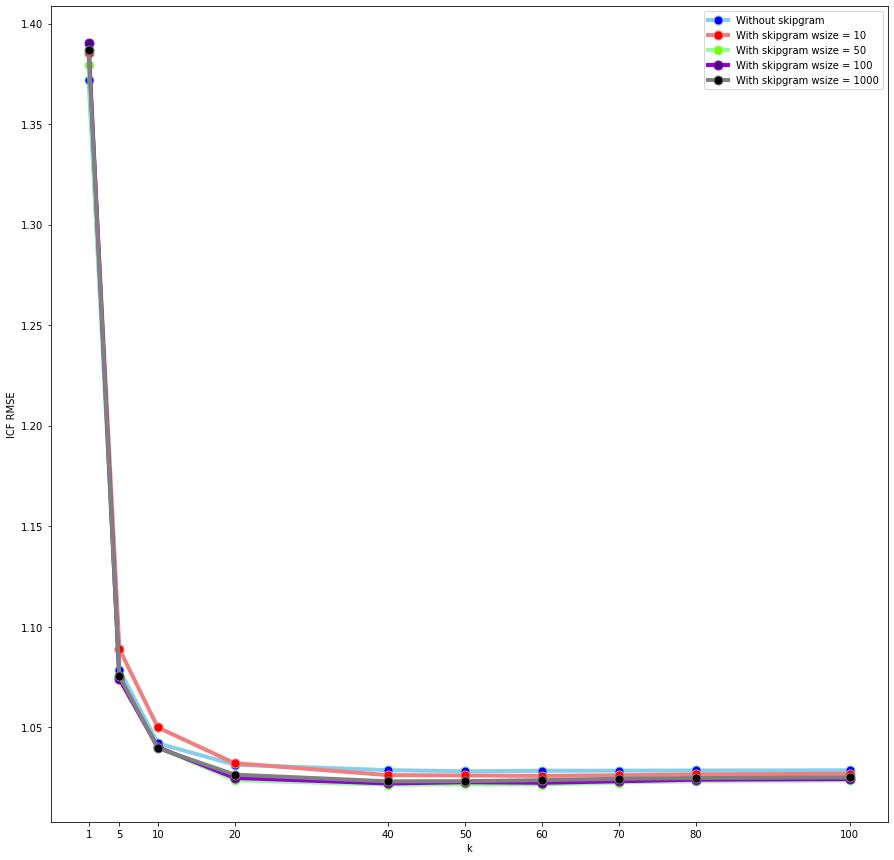

In [76]:
import matplotlib.pyplot as plt
import pandas as pd

# dataframe
df = pd.DataFrame({'ICF_k_values': ICF_k_values,  'ICF_RMSE_without_skipgram': ICF_RMSE_without_skipgram,
                  'ICF_RMSE_window_size_10': ICF_RMSE_window_size_10, 'ICF_RMSE_window_size_50': ICF_RMSE_window_size_50, 'ICF_RMSE_window_size_100': ICF_RMSE_window_size_100, 'ICF_RMSE_window_size_1000': ICF_RMSE_window_size_1000})
 
# multiple line plot
plt.figure(figsize = (15,15))
plt.ylabel('ICF RMSE')
plt.xlabel('k')
plt.xticks([1, 5, 10, 20, 40, 50, 60, 70, 80, 100])
plt.plot( 'ICF_k_values', 'ICF_RMSE_without_skipgram', data=df, marker='o', markerfacecolor='blue', markersize=9, color='skyblue', linewidth=4, label='Without skipgram')
plt.plot( 'ICF_k_values', 'ICF_RMSE_window_size_10', data=df, marker='o', markerfacecolor='red', markersize=9, color='lightcoral', linewidth=4, label='With skipgram wsize = 10')
plt.plot( 'ICF_k_values', 'ICF_RMSE_window_size_50', data=df, marker='o', markerfacecolor='lawngreen', markersize=9, color='palegreen', linewidth=4, label='With skipgram wsize = 50')
plt.plot( 'ICF_k_values', 'ICF_RMSE_window_size_100', data=df, marker='o', markerfacecolor='indigo', markersize=9, color='darkviolet', linewidth=4, label='With skipgram wsize = 100')
plt.plot( 'ICF_k_values', 'ICF_RMSE_window_size_1000', data=df, marker='o', markerfacecolor='black', markersize=9, color='gray', linewidth=4, label='With skipgram wsize = 1000')
plt.legend()

<h3>TASK 2</h3>

In [78]:
business_ratings_with_dates = {} # dictionary with business id's as keys and a dict of (user_id : date) pairs as values

with open('yelp_academic_dataset_review.json ', 'r', encoding = "utf8") as f1:   
    parser = ijson.parse(f1, multiple_values = True) 

    business_id = ''  
    user_id = ''
    date_str = ''
    
    for prefix, event, value in parser:
        if(prefix == "user_id"):
            user_id = value
        if(prefix == "business_id"):
            business_id = value
        if(prefix == "date"):
            date_str = value
            if(user_id in user_map.keys() and business_id in business_map.keys()): # we only need the dates of ratings that refer to our dataset
                if(R[user_map[user_id], business_map[business_id]] != 0): # we need to check that the rating is not of the 5% that has been removed (we shouldn't use this info for training)
                    if(business_id in business_ratings_with_dates.keys()):
                        business_ratings_with_dates[business_id][user_id] = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
                    else:
                        business_ratings_with_dates[business_id] = {user_id : datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")}
            business_id = ''  
            user_id = ''
            date_str = ''

In [95]:
print(business_ratings_with_dates.keys())

dict_keys(['qUWqjjjfpB2-4P3He5rsKw', 'nIIuxIn5RU0j-XkDWh3hlA', 'cDoo0Pf1d_P79Rq3ZNk-Mw', 'IfUkm42SB9D0m_ZbkQ711A', 'NrJSy3dgcXErFtOKGREmnw', 'nY2oBwH3s5sKox1mERIoVQ', 'PjtX-5vSTBVyWfMREX8bRA', '28adZ4lsuUeVB2aWzohK9g', '58h2EhvN3iJ4jeu95N5YzA', 'sSdHUsUZ4mvkb5ymIOJ_Aw', 'n-5dPbGyziS0SOkVDTquFQ', 'ZVSGswtLoZLAH9gzRAGf7A', 'GtQPbazps0jt7_cJghfmsA', 'W7Ua8ELRMm3IPd23fp7XjA', '7HrCELR6uv2HkgL7aT_hcQ', '_nUQ_iT_JEdkMN7c-wqkBQ', 'sjJOsKnXxsQodXMr1i8fsg', 'dvbcUnKv2awsIxog7dO4vw', 'Zx-rz7D4DOT8Kmx97LFAjw', 'Cyy95sS5r6MGzgEA4UZX5g', 'h_4dPV9M9aYaBliH1Eoeeg', '5iawpo9MaMaMcqtQxxbfqQ', '7v91woy8IpLrqXsRvxj_vw', 'BmV0ZAdepydSujYJH5_EQw', 'G-LwYGh6NdXKjqCKKSxQfw', 'nQxYkbV4P2h2HqJB0nfpxw', 'uPa5hrWmHm0n1l4MSyVMGQ', 'ZtkplJBLUa4PmZh_noUHEQ', 'kYZJ94hdzbhZIIXhIZU5Dw', 'w9pwbsusI9DI637UYqMctQ', 'tvYID0arhN-shKGUrC1Wsg', 'QNfh79NwsNnl-AngRhg2ww', 'cicPsia8Wj-DNRkmLbD_xg', 'cTbFJzHQzFSX-z3JF4abKQ', 'td1uEmND7zG8X9aNQyKCbg', 'OmZ_Ub_0egPc6eDPD1OWSw', 'cj_9eTPR0JBqk9qt2VmzFw', 'jo4KmAqlZ7vxjHIP7IIkAw', '

In [96]:
print(business_ratings_with_dates['nIIuxIn5RU0j-XkDWh3hlA'])

{'AdMCAKmNDIaubYPxnjTq1g': datetime.datetime(2018, 10, 4, 14, 12, 57), 'Q1M-ZNimeELw5J666FYrcg': datetime.datetime(2018, 10, 3, 19, 23, 18), 'yiHXyCxPenNg5ZWCXF95qQ': datetime.datetime(2018, 10, 24, 23, 44, 25), 'zzmhLxcZ4XZQyz95c_KbOA': datetime.datetime(2018, 11, 19, 1, 30, 34), 'CSxe7cFEyfTClJolLYqhUA': datetime.datetime(2018, 11, 3, 19, 53, 1), '2Dny4Ss81pUsUHcUWuprOw': datetime.datetime(2019, 3, 23, 22, 31, 46), 'orh0HRUNCWuQMt9Iia_osg': datetime.datetime(2018, 11, 21, 1, 29, 14), 'k6AIp3UhjeTErmR2NZUFYQ': datetime.datetime(2018, 12, 7, 3, 16, 2), 'YWkIeKGcuRFLwxcTBvn6Yg': datetime.datetime(2018, 11, 4, 18, 3, 47), 'rUnWDIvD-NxKDNEkr3h4fw': datetime.datetime(2018, 10, 16, 19, 4, 27), 'eY6TPklHTeOaQt9F8a_SGQ': datetime.datetime(2018, 12, 12, 2, 27, 51), 'CqE49Gu0rv4v2W41WbjOYQ': datetime.datetime(2018, 10, 13, 18, 54, 1), 'YyfKGEfpKX_v_o7I9yfQzw': datetime.datetime(2019, 1, 7, 5, 31, 43), 'p1F0HCgAggNfneVlFofTkA': datetime.datetime(2018, 11, 15, 14, 33, 38), 'ZBllYKrFzaI0I7v6Wl26Wg

In [97]:
for business_id in business_ratings_with_dates:
    business_ratings_with_dates[business_id] = dict(sorted(business_ratings_with_dates[business_id].items(), key=lambda item: item[1])) # sorting each dict by value (date)

In [98]:
print(business_ratings_with_dates['nIIuxIn5RU0j-XkDWh3hlA'])

{'Q1M-ZNimeELw5J666FYrcg': datetime.datetime(2018, 10, 3, 19, 23, 18), 'AdMCAKmNDIaubYPxnjTq1g': datetime.datetime(2018, 10, 4, 14, 12, 57), 'CqE49Gu0rv4v2W41WbjOYQ': datetime.datetime(2018, 10, 13, 18, 54, 1), 'rUnWDIvD-NxKDNEkr3h4fw': datetime.datetime(2018, 10, 16, 19, 4, 27), 'Hyro9mRdNtU2hJlkQjVq4Q': datetime.datetime(2018, 10, 23, 4, 17, 46), 'yiHXyCxPenNg5ZWCXF95qQ': datetime.datetime(2018, 10, 24, 23, 44, 25), 'CSxe7cFEyfTClJolLYqhUA': datetime.datetime(2018, 11, 3, 19, 53, 1), 'qy_fme4XHelLl2Cg5N9YNg': datetime.datetime(2018, 11, 4, 2, 52, 34), 'YWkIeKGcuRFLwxcTBvn6Yg': datetime.datetime(2018, 11, 4, 18, 3, 47), 'p1F0HCgAggNfneVlFofTkA': datetime.datetime(2018, 11, 15, 14, 33, 38), 'zzmhLxcZ4XZQyz95c_KbOA': datetime.datetime(2018, 11, 19, 1, 30, 34), 'hJ1ODk_lPKZ9iJxlxTOqnA': datetime.datetime(2018, 11, 19, 15, 15, 52), 'orh0HRUNCWuQMt9Iia_osg': datetime.datetime(2018, 11, 21, 1, 29, 14), 'eZeBuiVZWT7u3SktO7mv9w': datetime.datetime(2018, 11, 27, 4, 1, 55), 'ZBllYKrFzaI0I7v6Wl2

In [99]:
business_ratings_corpus = []

for business_id in business_ratings_with_dates:
    user_id_list = list(business_ratings_with_dates[business_id].keys())
    business_ratings_corpus.append(user_id_list)

In [100]:
print(business_ratings_corpus[0])

['TX5kwQLpKUDvNf4mfdaH3Q', 'q4O6ty6-tMeG1nc0Vi4hAw', 'pAH0GRL9uBTEqzuRAzOQLA', 'tpI40L14ncKqlXKtU8zCzA', 'uDPgnEv6jZa4CSv6NX49TQ', '2Ty2wSzp-qumjUL1dL-1Nw', 'YOOsYiXGEtGFX_wSeZNcww', 'TkAgUg_BMbBrR_zgNtaqWw', '87-KPVeEqoMpPez8d26jKg', 'n5HCox_qsCR-DidvPzyctA', 'rGd8YUtvhSdMm8-9cMdQ4Q', '7Kgk_H0Ge7x36nj0qWE8gQ', 'L0JvK1BtEe5Yz_rmclfcQA', '-KVxkJDSTjtPGsamMDG92Q', '9sv4lPr5owwLRzJPKkn6Vw', 'jhpYtJj6mijxNGWRARt7ew', 'Tjv5bBtJ-Z_CLiY-rheG2g', 'ic-tyi1jElL_umxZVh8KNA', 'mI4JiIhxbL_oNC6Dkd7pZg', 'ukp5bUGNcvl2OWU5CPG7fw', 'eY6TPklHTeOaQt9F8a_SGQ', 'VyDemwHXjk6oZ2emfB1NHw', 'npL9RrkAslHCf5JURxhl7w', 'PlZFrf9yocNgzvBHDlEGOQ', 'IAhSc_6mKxOCAUJVxDYeKg', 'GxzhQZokFig02SwfVhGQlA', 'P7S6JorjpamxAVSvmrmjXw', 'KgFOJnWXxVuz0b-xfo6jjw', 'vQ5TMhkJHt8Wt8A1kDAzbg', 'w2wFvtGWp7ZGMe-T9fsRIA', 'bCLqNCdhUdsmTj9Braespg', 'fM9LC2P8jQrQGGsXKccLQw', 'izdAXYjPdwaztxuT6C7GvQ', 'pFCb-1j6oI3TDjr26h2cJQ', 'eRDWzHCldd6YXypRECvHYg', 'fSYQ_oQ0wNGk2nMJLvNZJA', 'aIg29snwGTFBzkV7HtDHfg', 'x_bHnIh87kEXYLh0T8u-aw', '0_iROv6FL4

In [102]:
embedding_size = 100 # professor asked us to keep this costant
skipgram_model = gensim.models.Word2Vec(business_ratings_corpus, min_count = 1,size = embedding_size, window = 50, sg = 1) 

In [103]:
print(skipgram_model.wv['TX5kwQLpKUDvNf4mfdaH3Q']) # checking a user vector

[ 0.23657459  0.23933947  0.02360953  0.13455433  0.22096923 -0.28294218
 -0.04363453  0.10560576  0.03038195 -0.02795989  0.13874905 -0.21027471
  0.15127502  0.0900925  -0.00787219  0.18032795 -0.00266131  0.04183869
 -0.09850001  0.21589878  0.2855924   0.09945031  0.11048444  0.08920701
 -0.27435264  0.20341675  0.12022593 -0.03293882  0.00456754 -0.24600191
 -0.10826765  0.35252708  0.34113184 -0.22743317  0.03947498  0.22054462
 -0.11547822 -0.15078798 -0.203594   -0.07333817  0.28791025  0.11714563
 -0.16930717  0.05870086 -0.2426059  -0.31410128 -0.22780441  0.08772179
  0.06419068 -0.0724823  -0.11358406 -0.02568753 -0.22194238  0.0758836
  0.04500404  0.02783805  0.24133018 -0.11676434 -0.0171433  -0.05482697
 -0.34411693 -0.0570591  -0.03485547 -0.21616891  0.2863731  -0.11091397
 -0.2531923  -0.00654888 -0.01022595 -0.2148453  -0.12933615  0.17417583
 -0.12274595 -0.01491875  0.17282896 -0.10021849  0.00155669 -0.00105534
 -0.26503032 -0.2611802  -0.27553043  0.18433501  0.

<p style="font-size:110%;">Similarly with task 1, we create the matrix that will store the skipgram vectors of each corresponding business, so that we can compute the cosine similarity.</p>

In [104]:
print(max(user_has_reviewed.keys())) 

4793


<p style="font-size:110%;"> Printed the maximum user index so that I know how many users there are for the matrix initialisation. </p>

In [107]:
user2vecMatrix = np.zeros([4794, embedding_size])

for user_id in skipgram_model.wv.vocab:
    user_index = user_map[user_id]
    user2vecMatrix[user_index] = skipgram_model.wv[user_id]
    
print(user2vecMatrix)

[[ 0.14652848  0.16050526 -0.00733988 ...  0.16123898 -0.29222888
  -0.44240183]
 [-0.10021283  0.06939246  0.00296431 ...  0.02811824 -0.0819845
  -0.01870121]
 [-0.33003664  0.16431974  0.12993266 ...  0.28695288 -0.1072956
  -0.31587464]
 ...
 [-0.35793769 -0.01409919 -0.2956003  ...  0.32324156 -0.04392151
   0.01020626]
 [-0.28795817  0.19104654  0.13142531 ...  0.35705996  0.22679804
  -0.05147065]
 [ 0.37618825  0.48022634 -0.18501791 ...  0.12790702  0.02488675
  -0.36265156]]


<p style="font-size:110%;"> Now that I've shown the way we come up with the necessary matrix, I must paraeterise the UCF function I had created in the previous set of exercises in order to also have a window size as parameter. Using the parameters, the function will need to be creating a skipgram model, a user2vecMatrix and through that matrix compute the cosine similarities between the users. The rest of the steps remain the same. </p>

In [111]:
# User-Based Collaborative Filtering (UCF) using skipgram model for similarity

def UCF_using_skipgram(k, window_size):
    
    skipgram_model_for_UCF = gensim.models.Word2Vec(business_ratings_corpus, min_count = 1, size = embedding_size, window = window_size, sg = 1) 
    user2vecMatrixUCF = np.zeros([4794, embedding_size])

    for user_id in skipgram_model_for_UCF.wv.vocab:
        user_index = user_map[user_id]
        user2vecMatrixUCF[user_index] = skipgram_model_for_UCF.wv[user_id]
    
    similarity_matrix = metrics.pairwise.cosine_similarity(user2vecMatrixUCF, Y=None, dense_output=True)
    predicted_missing_ratings = []
    
    u_pos = -1 # index that will be used to get each user index from the removedUserPositions list

    R_Array = R.toarray()

    for b in removedBusinessPositions:

        u_pos += 1
        u = removedUserPositions[u_pos]

        users_that_reviewed = business_rated_by[b] # we need all the users that reviewed this business for similarity computations

        if u in users_that_reviewed:
            users_that_reviewed.remove(u) # the same user shouldn't appear twice

        user_similarities = []
        user_dict = {}

        for user in users_that_reviewed: # get the similarities with each user that reviewed the same business
            similarity = similarity_matrix[user, u]
            user_similarities.append(similarity)
            user_dict[similarity] = user

        user_similarities = np.array(user_similarities)
        k_most_similar_similarities = []
        
        if(len(user_similarities) > k):
            k_most_similar_similarities = np.partition(user_similarities, -k)[-k:]
        else: # in this case we have less than k users that reviewed the same business, so we keep all the users
            k_most_similar_similarities = user_similarities
        k_most_similar_users = []
        k_most_similar_ratings = []

        for similarity in k_most_similar_similarities: # store the k most similar users
            k_most_similar_users.append(user_dict[similarity])

        for user in k_most_similar_users: # store the ratings of those users
            k_most_similar_ratings.append(R_Array[user,b])    

        k_most_similar_ratings = np.array(k_most_similar_ratings)

        predicted_rating = np.inner(k_most_similar_similarities, k_most_similar_ratings) / np.sum(k_most_similar_similarities)
        predicted_missing_ratings.append(predicted_rating)
        
    return predicted_missing_ratings

predictions = UCF_using_skipgram(10, 50) # testing the method and printing its results

for i in range(len(predictions)):
    print("Removed rating: ", removedRatings[i], " Prediction: ", predictions[i] )

Removed rating:  2.0  Prediction:  3.0290906714212396
Removed rating:  2.0  Prediction:  3.445490569960635
Removed rating:  4.0  Prediction:  3.8499406448189006
Removed rating:  3.0  Prediction:  3.237122450245672
Removed rating:  3.0  Prediction:  3.1721317172052808
Removed rating:  1.0  Prediction:  2.8236997474629835
Removed rating:  4.0  Prediction:  3.2667887822435904
Removed rating:  4.0  Prediction:  3.891877825468173
Removed rating:  4.0  Prediction:  3.309316392899233
Removed rating:  4.0  Prediction:  3.406866085584033
Removed rating:  3.0  Prediction:  3.9472479370278504
Removed rating:  4.0  Prediction:  3.700362348179005
Removed rating:  3.0  Prediction:  4.412398627087861
Removed rating:  2.0  Prediction:  3.4297436513333297
Removed rating:  5.0  Prediction:  4.100352857873505
Removed rating:  4.0  Prediction:  3.6946579403712208
Removed rating:  3.0  Prediction:  2.6300998384773058
Removed rating:  1.0  Prediction:  3.913309426615494
Removed rating:  5.0  Prediction:  4.

Removed rating:  4.0  Prediction:  4.112335674116981
Removed rating:  2.0  Prediction:  3.5993044372290743
Removed rating:  4.0  Prediction:  3.307186589087721
Removed rating:  3.0  Prediction:  3.499380975737083
Removed rating:  3.0  Prediction:  3.074133778683486
Removed rating:  4.0  Prediction:  2.706333161836568
Removed rating:  4.0  Prediction:  3.9464716881591726
Removed rating:  3.0  Prediction:  3.8125397542974806
Removed rating:  4.0  Prediction:  3.2327397351052474
Removed rating:  5.0  Prediction:  3.909980871641924
Removed rating:  4.0  Prediction:  2.81839010798815
Removed rating:  5.0  Prediction:  3.4885819935286384
Removed rating:  4.0  Prediction:  2.6328405358051143
Removed rating:  3.0  Prediction:  3.7040665320481145
Removed rating:  4.0  Prediction:  3.7116953180048946
Removed rating:  5.0  Prediction:  3.3611217817340346
Removed rating:  2.0  Prediction:  3.4971826134546204
Removed rating:  4.0  Prediction:  3.5956084195631126
Removed rating:  4.0  Prediction:  3

Removed rating:  4.0  Prediction:  3.2705868474452475
Removed rating:  3.0  Prediction:  3.6835834976811808
Removed rating:  5.0  Prediction:  4.304865914580459
Removed rating:  2.0  Prediction:  2.675174423252376
Removed rating:  4.0  Prediction:  4.1777704515357135
Removed rating:  4.0  Prediction:  3.5179020675723995
Removed rating:  2.0  Prediction:  3.11332576542201
Removed rating:  5.0  Prediction:  3.32489395636662
Removed rating:  4.0  Prediction:  4.403360920270662
Removed rating:  3.0  Prediction:  3.6613650256672794
Removed rating:  3.0  Prediction:  3.736877569606671
Removed rating:  3.0  Prediction:  3.0177755994929263
Removed rating:  4.0  Prediction:  3.3910431381179422
Removed rating:  3.0  Prediction:  4.008053382890898
Removed rating:  4.0  Prediction:  3.4523950350823247
Removed rating:  4.0  Prediction:  3.3253805177966256
Removed rating:  4.0  Prediction:  3.2468680692995298
Removed rating:  4.0  Prediction:  3.5015829687856357
Removed rating:  4.0  Prediction:  3.

Removed rating:  4.0  Prediction:  3.618939351921852
Removed rating:  4.0  Prediction:  4.382593694531983
Removed rating:  3.0  Prediction:  3.8818379139706143
Removed rating:  4.0  Prediction:  3.3963467435674604
Removed rating:  4.0  Prediction:  3.8419136734935506
Removed rating:  5.0  Prediction:  3.102644371723839
Removed rating:  4.0  Prediction:  4.508159960613592
Removed rating:  4.0  Prediction:  3.794209785067928
Removed rating:  5.0  Prediction:  3.906995404371541
Removed rating:  5.0  Prediction:  4.111152580304773
Removed rating:  5.0  Prediction:  3.7127815228017695
Removed rating:  4.0  Prediction:  3.8898570363725895
Removed rating:  5.0  Prediction:  3.778243431696347
Removed rating:  4.0  Prediction:  3.7859622089126126
Removed rating:  4.0  Prediction:  3.888650671961863
Removed rating:  1.0  Prediction:  3.6487291168060865
Removed rating:  5.0  Prediction:  3.1182330962775784
Removed rating:  1.0  Prediction:  2.552428834790177
Removed rating:  4.0  Prediction:  3.3

Removed rating:  3.0  Prediction:  3.9551113813276335
Removed rating:  5.0  Prediction:  3.4716539141042944
Removed rating:  3.0  Prediction:  3.628250806016225
Removed rating:  3.0  Prediction:  3.1954747274077993
Removed rating:  5.0  Prediction:  3.9801494444663192
Removed rating:  5.0  Prediction:  4.694397668756252
Removed rating:  5.0  Prediction:  3.8614200585756566
Removed rating:  1.0  Prediction:  4.090828133698865
Removed rating:  5.0  Prediction:  4.396724363090685
Removed rating:  5.0  Prediction:  3.3929656648393975
Removed rating:  4.0  Prediction:  3.792385907810182
Removed rating:  1.0  Prediction:  3.281552801782986
Removed rating:  4.0  Prediction:  2.333782832001556
Removed rating:  5.0  Prediction:  2.6338237744390014
Removed rating:  4.0  Prediction:  4.18429080243577
Removed rating:  5.0  Prediction:  2.7718841671452576
Removed rating:  4.0  Prediction:  3.7914050940776445
Removed rating:  4.0  Prediction:  4.276926530173952
Removed rating:  3.0  Prediction:  3.7

Removed rating:  4.0  Prediction:  3.814379487886325
Removed rating:  5.0  Prediction:  4.008486038546008
Removed rating:  5.0  Prediction:  4.105577954246387
Removed rating:  5.0  Prediction:  1.8931272566363442
Removed rating:  3.0  Prediction:  3.498719214310542
Removed rating:  4.0  Prediction:  3.0933977291477097
Removed rating:  5.0  Prediction:  4.1984103983828325
Removed rating:  4.0  Prediction:  3.7264112221173025
Removed rating:  1.0  Prediction:  3.3139839365506325
Removed rating:  4.0  Prediction:  3.472904310256528
Removed rating:  3.0  Prediction:  3.297150073379336
Removed rating:  2.0  Prediction:  3.500785158287446
Removed rating:  5.0  Prediction:  4.803105089595436
Removed rating:  3.0  Prediction:  3.7252733718776945
Removed rating:  5.0  Prediction:  3.982480209824995
Removed rating:  5.0  Prediction:  4.006529282810521
Removed rating:  3.0  Prediction:  4.118779737719516
Removed rating:  3.0  Prediction:  3.806147947487952
Removed rating:  4.0  Prediction:  4.003

Removed rating:  4.0  Prediction:  3.5034597748161267
Removed rating:  4.0  Prediction:  3.8184746923253923
Removed rating:  1.0  Prediction:  2.6677296870797096
Removed rating:  4.0  Prediction:  3.7841845297046133
Removed rating:  1.0  Prediction:  3.1821297228970455
Removed rating:  3.0  Prediction:  3.421287411397032
Removed rating:  3.0  Prediction:  4.428146920657891
Removed rating:  3.0  Prediction:  4.387374574526018
Removed rating:  3.0  Prediction:  2.677922426772706
Removed rating:  5.0  Prediction:  4.3568069693296945
Removed rating:  3.0  Prediction:  3.3081008184734544
Removed rating:  4.0  Prediction:  3.07308898505894
Removed rating:  4.0  Prediction:  4.418270201745983
Removed rating:  5.0  Prediction:  4.0933734320722435
Removed rating:  1.0  Prediction:  3.1484005020836157
Removed rating:  3.0  Prediction:  3.2273690498812195
Removed rating:  3.0  Prediction:  3.584994641086745
Removed rating:  3.0  Prediction:  3.1877476254955406
Removed rating:  2.0  Prediction:  3

Removed rating:  5.0  Prediction:  4.183014416882601
Removed rating:  4.0  Prediction:  4.324535238127824
Removed rating:  4.0  Prediction:  3.0918382826371045
Removed rating:  3.0  Prediction:  4.609007264431703
Removed rating:  4.0  Prediction:  2.594685593405848
Removed rating:  3.0  Prediction:  3.699802423878757
Removed rating:  2.0  Prediction:  3.0410067918647643
Removed rating:  2.0  Prediction:  2.9478478038039113
Removed rating:  3.0  Prediction:  3.3093493809867054
Removed rating:  2.0  Prediction:  3.34114577763848
Removed rating:  3.0  Prediction:  3.072418461406868
Removed rating:  5.0  Prediction:  4.220000477673397
Removed rating:  5.0  Prediction:  4.1377316354929965
Removed rating:  1.0  Prediction:  3.5964436299214424
Removed rating:  4.0  Prediction:  2.981098642544105
Removed rating:  4.0  Prediction:  4.136011653309174
Removed rating:  4.0  Prediction:  2.694861426120444
Removed rating:  4.0  Prediction:  3.377547994940964
Removed rating:  4.0  Prediction:  3.8024

Removed rating:  4.0  Prediction:  4.251470936565399
Removed rating:  2.0  Prediction:  3.918757071199998
Removed rating:  4.0  Prediction:  3.7169277938142034
Removed rating:  2.0  Prediction:  2.7979972637169017
Removed rating:  1.0  Prediction:  3.435491140278006
Removed rating:  3.0  Prediction:  2.7832918401320166
Removed rating:  4.0  Prediction:  3.978690097566661
Removed rating:  4.0  Prediction:  3.990556594100869
Removed rating:  5.0  Prediction:  3.809528673343932
Removed rating:  4.0  Prediction:  3.497597481493016
Removed rating:  4.0  Prediction:  3.752169102898949
Removed rating:  3.0  Prediction:  2.632072075901067
Removed rating:  4.0  Prediction:  3.692639050415386
Removed rating:  3.0  Prediction:  3.993097327577766
Removed rating:  5.0  Prediction:  3.7227461841138174
Removed rating:  5.0  Prediction:  4.139240268313497
Removed rating:  4.0  Prediction:  3.3608878818973573
Removed rating:  4.0  Prediction:  3.5099838768843146
Removed rating:  4.0  Prediction:  4.203

Removed rating:  5.0  Prediction:  3.816973826161599
Removed rating:  2.0  Prediction:  3.076783116476857
Removed rating:  4.0  Prediction:  3.5686617940939267
Removed rating:  5.0  Prediction:  4.100029262725597
Removed rating:  2.0  Prediction:  3.698822074042623
Removed rating:  5.0  Prediction:  2.7930495905645594
Removed rating:  2.0  Prediction:  4.190951709062718
Removed rating:  3.0  Prediction:  2.4126175192657815
Removed rating:  3.0  Prediction:  2.872999705548513
Removed rating:  5.0  Prediction:  3.196316160349384
Removed rating:  5.0  Prediction:  3.986389947262591
Removed rating:  3.0  Prediction:  3.757116298983099
Removed rating:  2.0  Prediction:  4.284454585519375
Removed rating:  3.0  Prediction:  4.013751718419265
Removed rating:  4.0  Prediction:  4.320713416121116
Removed rating:  3.0  Prediction:  3.6158288684742073
Removed rating:  1.0  Prediction:  2.0983526375451564
Removed rating:  2.0  Prediction:  3.3943021224092305
Removed rating:  3.0  Prediction:  2.863

Removed rating:  2.0  Prediction:  4.202305425092142
Removed rating:  5.0  Prediction:  3.918159634586564
Removed rating:  3.0  Prediction:  2.992064668048197
Removed rating:  4.0  Prediction:  4.489551192713015
Removed rating:  2.0  Prediction:  2.880890116313052
Removed rating:  2.0  Prediction:  3.0823824538228153
Removed rating:  4.0  Prediction:  3.354263825796142
Removed rating:  4.0  Prediction:  4.608817334408097
Removed rating:  4.0  Prediction:  3.7570155161531806
Removed rating:  2.0  Prediction:  2.987012381408337
Removed rating:  4.0  Prediction:  3.110025857552941
Removed rating:  3.0  Prediction:  3.099728848441689
Removed rating:  4.0  Prediction:  3.300523768891814
Removed rating:  2.0  Prediction:  3.177073191546277
Removed rating:  4.0  Prediction:  3.4095182349451836
Removed rating:  4.0  Prediction:  2.867859632649193
Removed rating:  4.0  Prediction:  4.31042719001263
Removed rating:  5.0  Prediction:  4.105118326194468
Removed rating:  4.0  Prediction:  4.5033198

Removed rating:  5.0  Prediction:  3.1876893488857454
Removed rating:  5.0  Prediction:  3.8619780444068987
Removed rating:  3.0  Prediction:  4.275394518466601
Removed rating:  5.0  Prediction:  3.375380366885873
Removed rating:  3.0  Prediction:  3.866493427315415
Removed rating:  4.0  Prediction:  3.7828163965795873
Removed rating:  3.0  Prediction:  3.1828315270262113
Removed rating:  2.0  Prediction:  2.999516284291979
Removed rating:  3.0  Prediction:  3.6954416308852975
Removed rating:  4.0  Prediction:  4.396295444709686
Removed rating:  5.0  Prediction:  3.756095742633865
Removed rating:  4.0  Prediction:  4.796876914325889
Removed rating:  5.0  Prediction:  3.789597434243815
Removed rating:  3.0  Prediction:  3.6903966761008946
Removed rating:  4.0  Prediction:  3.688359261894252
Removed rating:  5.0  Prediction:  3.50040956344269
Removed rating:  2.0  Prediction:  3.6127682029728887
Removed rating:  3.0  Prediction:  2.901796329445212
Removed rating:  5.0  Prediction:  3.550

Removed rating:  4.0  Prediction:  3.7105930662693454
Removed rating:  4.0  Prediction:  3.51746179216871
Removed rating:  5.0  Prediction:  3.8886368969985905
Removed rating:  3.0  Prediction:  3.275776805046755
Removed rating:  5.0  Prediction:  4.600783283316351
Removed rating:  2.0  Prediction:  3.367914364921463
Removed rating:  4.0  Prediction:  4.125628904607409
Removed rating:  1.0  Prediction:  3.1074619881138292
Removed rating:  5.0  Prediction:  3.102781591123627
Removed rating:  4.0  Prediction:  4.0276595641426365
Removed rating:  3.0  Prediction:  4.296252477403338
Removed rating:  4.0  Prediction:  3.8000778249423166
Removed rating:  4.0  Prediction:  3.839048544511474
Removed rating:  3.0  Prediction:  2.766020143904755
Removed rating:  4.0  Prediction:  3.89353453460878
Removed rating:  2.0  Prediction:  4.08410676733022
Removed rating:  3.0  Prediction:  4.15693397450788
Removed rating:  4.0  Prediction:  3.256067442678034
Removed rating:  4.0  Prediction:  3.95445529

Removed rating:  1.0  Prediction:  3.166441760808869
Removed rating:  4.0  Prediction:  3.8099241667892922
Removed rating:  5.0  Prediction:  3.1869275617936337
Removed rating:  5.0  Prediction:  4.301105801361234
Removed rating:  3.0  Prediction:  2.940098875967312
Removed rating:  4.0  Prediction:  4.01127925883176
Removed rating:  3.0  Prediction:  3.246778594172477
Removed rating:  3.0  Prediction:  4.216706696632441
Removed rating:  5.0  Prediction:  3.628182523123418
Removed rating:  5.0  Prediction:  2.928939780289195
Removed rating:  3.0  Prediction:  3.6097528219088564
Removed rating:  5.0  Prediction:  3.315830374923359
Removed rating:  2.0  Prediction:  3.534990788399865
Removed rating:  4.0  Prediction:  4.198256781567834
Removed rating:  4.0  Prediction:  3.678081045351531
Removed rating:  3.0  Prediction:  3.598449602779005
Removed rating:  2.0  Prediction:  3.510133402480059
Removed rating:  4.0  Prediction:  3.7117876772787888
Removed rating:  3.0  Prediction:  3.292365

Removed rating:  4.0  Prediction:  4.00624155661169
Removed rating:  4.0  Prediction:  3.3143711432816416
Removed rating:  4.0  Prediction:  3.500103482497724
Removed rating:  2.0  Prediction:  2.569068022180563
Removed rating:  5.0  Prediction:  4.588797015266379
Removed rating:  4.0  Prediction:  3.7973027962794927
Removed rating:  2.0  Prediction:  3.284030862910326
Removed rating:  4.0  Prediction:  4.173357579874234
Removed rating:  4.0  Prediction:  4.209972195470514
Removed rating:  4.0  Prediction:  2.8977031020490363
Removed rating:  4.0  Prediction:  3.3245087380265215
Removed rating:  5.0  Prediction:  2.978520945656361
Removed rating:  4.0  Prediction:  3.52239698512461
Removed rating:  4.0  Prediction:  4.3967015863756735
Removed rating:  4.0  Prediction:  3.5990027986520374
Removed rating:  1.0  Prediction:  2.494077750975466
Removed rating:  5.0  Prediction:  3.6155235087891473
Removed rating:  4.0  Prediction:  3.2505086666764593
Removed rating:  5.0  Prediction:  4.013

Removed rating:  4.0  Prediction:  3.8113401371206197
Removed rating:  4.0  Prediction:  3.522037768660181
Removed rating:  5.0  Prediction:  2.8707259321309495
Removed rating:  5.0  Prediction:  2.516381024763223
Removed rating:  4.0  Prediction:  2.713622392990336
Removed rating:  5.0  Prediction:  2.513644189766489
Removed rating:  2.0  Prediction:  3.7923120162573647
Removed rating:  4.0  Prediction:  3.7816205464971047
Removed rating:  2.0  Prediction:  2.605552192493469
Removed rating:  5.0  Prediction:  4.207875361873957
Removed rating:  4.0  Prediction:  2.129781980365747
Removed rating:  4.0  Prediction:  3.638340542811184
Removed rating:  4.0  Prediction:  3.8089328112695564
Removed rating:  3.0  Prediction:  4.785336489947278
Removed rating:  1.0  Prediction:  2.9964483678464684
Removed rating:  4.0  Prediction:  2.6937744213090555
Removed rating:  4.0  Prediction:  3.689547651303794
Removed rating:  3.0  Prediction:  3.9066524382236167
Removed rating:  2.0  Prediction:  3.4

Removed rating:  4.0  Prediction:  2.895150046106787
Removed rating:  3.0  Prediction:  3.2487330695445893
Removed rating:  5.0  Prediction:  3.6971703224828962
Removed rating:  5.0  Prediction:  3.0659666880524785
Removed rating:  3.0  Prediction:  3.3026870097366134
Removed rating:  3.0  Prediction:  4.285445231013492
Removed rating:  5.0  Prediction:  4.591518625177901
Removed rating:  4.0  Prediction:  3.9748307900683377
Removed rating:  4.0  Prediction:  3.1504187813856177
Removed rating:  1.0  Prediction:  1.801216549458835
Removed rating:  5.0  Prediction:  4.233652331750861
Removed rating:  3.0  Prediction:  3.3100870194817484
Removed rating:  4.0  Prediction:  3.6611421994568856
Removed rating:  3.0  Prediction:  4.3055803221243085
Removed rating:  5.0  Prediction:  4.267815816459503
Removed rating:  4.0  Prediction:  3.2169937440310723
Removed rating:  2.0  Prediction:  4.2225329243833984
Removed rating:  5.0  Prediction:  3.89912365706152
Removed rating:  3.0  Prediction:  2

Removed rating:  5.0  Prediction:  3.2946299457887633
Removed rating:  2.0  Prediction:  3.6821406118008984
Removed rating:  2.0  Prediction:  3.0006688586449086
Removed rating:  2.0  Prediction:  3.0898733618881122
Removed rating:  5.0  Prediction:  3.7754211647570064
Removed rating:  5.0  Prediction:  4.233617692813939
Removed rating:  3.0  Prediction:  3.692666162991575
Removed rating:  3.0  Prediction:  3.597135005774599
Removed rating:  4.0  Prediction:  3.7862158506850907
Removed rating:  4.0  Prediction:  2.3712991623158732
Removed rating:  5.0  Prediction:  3.8235793551738255
Removed rating:  4.0  Prediction:  3.605214863474454
Removed rating:  4.0  Prediction:  2.59955845764981
Removed rating:  4.0  Prediction:  3.315865223694792
Removed rating:  4.0  Prediction:  4.315645574059466
Removed rating:  4.0  Prediction:  3.0263238831319716
Removed rating:  4.0  Prediction:  3.627084503435054
Removed rating:  4.0  Prediction:  3.5862523679346583
Removed rating:  5.0  Prediction:  3.

Removed rating:  3.0  Prediction:  4.501118641066357
Removed rating:  4.0  Prediction:  3.8254914592700278
Removed rating:  3.0  Prediction:  3.517390405602273
Removed rating:  3.0  Prediction:  3.415170303373866
Removed rating:  5.0  Prediction:  2.7725504661765945
Removed rating:  5.0  Prediction:  3.4877764502161255
Removed rating:  5.0  Prediction:  3.292410376525828
Removed rating:  4.0  Prediction:  3.7141516369330767
Removed rating:  5.0  Prediction:  3.3290121775138917
Removed rating:  4.0  Prediction:  4.120405015961371
Removed rating:  5.0  Prediction:  4.525512485158978
Removed rating:  4.0  Prediction:  3.748255067681761
Removed rating:  2.0  Prediction:  3.8885797586398096
Removed rating:  4.0  Prediction:  4.664438202981868
Removed rating:  5.0  Prediction:  4.681395866055113
Removed rating:  1.0  Prediction:  2.3960561960626507
Removed rating:  4.0  Prediction:  4.106470386740977
Removed rating:  4.0  Prediction:  3.4021778336680666
Removed rating:  4.0  Prediction:  4.0

Removed rating:  5.0  Prediction:  4.107814908879645
Removed rating:  4.0  Prediction:  3.6094847059799178
Removed rating:  4.0  Prediction:  4.285699339818546
Removed rating:  4.0  Prediction:  3.509752468064658
Removed rating:  3.0  Prediction:  3.10952186528756
Removed rating:  4.0  Prediction:  2.9773132765737165
Removed rating:  4.0  Prediction:  4.100607769448141
Removed rating:  5.0  Prediction:  3.922267050431782
Removed rating:  5.0  Prediction:  3.621556621389229
Removed rating:  3.0  Prediction:  4.078194381788198
Removed rating:  3.0  Prediction:  2.8840479313369434
Removed rating:  2.0  Prediction:  3.6994989163741625
Removed rating:  2.0  Prediction:  4.015555558276855
Removed rating:  5.0  Prediction:  3.9147049146867623
Removed rating:  4.0  Prediction:  2.9287687998374756
Removed rating:  1.0  Prediction:  2.9326476280737013
Removed rating:  4.0  Prediction:  3.615213802501977
Removed rating:  1.0  Prediction:  3.841494608831606
Removed rating:  3.0  Prediction:  3.089

Removed rating:  3.0  Prediction:  3.5831334955171528
Removed rating:  2.0  Prediction:  2.567301628347967
Removed rating:  3.0  Prediction:  2.7175630350507363
Removed rating:  5.0  Prediction:  4.517320597712441
Removed rating:  3.0  Prediction:  3.305991501495985
Removed rating:  5.0  Prediction:  4.206184240999522
Removed rating:  5.0  Prediction:  4.0008619500889875
Removed rating:  5.0  Prediction:  3.877459067688741
Removed rating:  3.0  Prediction:  3.5948073875330575
Removed rating:  1.0  Prediction:  3.639840868972472
Removed rating:  3.0  Prediction:  3.210782660348185
Removed rating:  4.0  Prediction:  3.6785440516854906
Removed rating:  5.0  Prediction:  3.8220341111007237
Removed rating:  4.0  Prediction:  3.0296325237679844
Removed rating:  3.0  Prediction:  4.1071118621606155
Removed rating:  5.0  Prediction:  3.913252895106218
Removed rating:  4.0  Prediction:  4.208181568561236
Removed rating:  3.0  Prediction:  3.0755963477212056
Removed rating:  3.0  Prediction:  4.

Removed rating:  3.0  Prediction:  3.6976268075706344
Removed rating:  1.0  Prediction:  2.9055326330755764
Removed rating:  2.0  Prediction:  3.8990657594315654
Removed rating:  4.0  Prediction:  2.7887044409048642
Removed rating:  4.0  Prediction:  4.305608337929938
Removed rating:  5.0  Prediction:  4.205197075462492
Removed rating:  3.0  Prediction:  3.194129428130122
Removed rating:  3.0  Prediction:  3.7968762948245613
Removed rating:  5.0  Prediction:  4.084460462101174
Removed rating:  4.0  Prediction:  3.8603155945264875
Removed rating:  4.0  Prediction:  4.404828253877041
Removed rating:  4.0  Prediction:  3.908543654552211
Removed rating:  4.0  Prediction:  3.8080879103142857
Removed rating:  2.0  Prediction:  3.09199366434128
Removed rating:  5.0  Prediction:  3.6099450759873735
Removed rating:  5.0  Prediction:  4.207094566528375
Removed rating:  4.0  Prediction:  3.513477166720158
Removed rating:  4.0  Prediction:  4.3921687525893285
Removed rating:  2.0  Prediction:  2.1

Removed rating:  4.0  Prediction:  3.4087813306832095
Removed rating:  5.0  Prediction:  3.2605517510461035
Removed rating:  4.0  Prediction:  3.691479029591447
Removed rating:  5.0  Prediction:  3.904583042132917
Removed rating:  4.0  Prediction:  4.095637460405643
Removed rating:  4.0  Prediction:  3.3129929872748516
Removed rating:  4.0  Prediction:  2.5950079572426317
Removed rating:  3.0  Prediction:  3.5866428640762438
Removed rating:  4.0  Prediction:  4.3248885982865275
Removed rating:  2.0  Prediction:  4.214658987234994
Removed rating:  4.0  Prediction:  4.401810827474447
Removed rating:  5.0  Prediction:  4.3165405695869845
Removed rating:  2.0  Prediction:  1.9803791982340542
Removed rating:  3.0  Prediction:  3.6095962513948603
Removed rating:  5.0  Prediction:  4.002360673964103
Removed rating:  3.0  Prediction:  3.8085197729000813
Removed rating:  2.0  Prediction:  4.026954309132181
Removed rating:  5.0  Prediction:  4.130682451653731
Removed rating:  5.0  Prediction:  3

Removed rating:  4.0  Prediction:  3.2191761079949206
Removed rating:  1.0  Prediction:  3.473625994472264
Removed rating:  4.0  Prediction:  3.602965510593229
Removed rating:  3.0  Prediction:  2.7195158110890394
Removed rating:  3.0  Prediction:  1.5544039578639215
Removed rating:  5.0  Prediction:  3.381135312105336
Removed rating:  4.0  Prediction:  3.8030798002985193
Removed rating:  5.0  Prediction:  3.9166797987691515
Removed rating:  3.0  Prediction:  3.546324728260482
Removed rating:  3.0  Prediction:  3.6032677579880947
Removed rating:  5.0  Prediction:  3.923512153806997
Removed rating:  5.0  Prediction:  3.7817749927487156
Removed rating:  4.0  Prediction:  2.9301245928406656
Removed rating:  2.0  Prediction:  3.607143077119254
Removed rating:  4.0  Prediction:  4.325275919323657
Removed rating:  5.0  Prediction:  2.9873551086456667
Removed rating:  3.0  Prediction:  4.012688893500369
Removed rating:  5.0  Prediction:  3.8944705494083496
Removed rating:  4.0  Prediction:  3

Removed rating:  3.0  Prediction:  2.6106406129968502
Removed rating:  5.0  Prediction:  4.515924059068878
Removed rating:  4.0  Prediction:  3.4031733991706483
Removed rating:  5.0  Prediction:  3.7901450445358846
Removed rating:  4.0  Prediction:  3.5879571833484847
Removed rating:  2.0  Prediction:  4.274543901101622
Removed rating:  5.0  Prediction:  3.2001387647984805
Removed rating:  4.0  Prediction:  3.314999372835305
Removed rating:  4.0  Prediction:  2.712220391432454
Removed rating:  3.0  Prediction:  3.711795061071988
Removed rating:  4.0  Prediction:  1.7786647869368033
Removed rating:  5.0  Prediction:  4.32671464467275
Removed rating:  4.0  Prediction:  4.30175411577519
Removed rating:  2.0  Prediction:  3.8841457089241493
Removed rating:  3.0  Prediction:  3.6014025516800934
Removed rating:  4.0  Prediction:  3.590203454786641
Removed rating:  2.0  Prediction:  2.4939901567584997
Removed rating:  2.0  Prediction:  4.406137628338442
Removed rating:  5.0  Prediction:  3.68

Removed rating:  1.0  Prediction:  4.023069919722373
Removed rating:  4.0  Prediction:  3.6441714001383523
Removed rating:  4.0  Prediction:  4.111007547844388
Removed rating:  4.0  Prediction:  2.827859054054427
Removed rating:  2.0  Prediction:  2.3003583879475897
Removed rating:  3.0  Prediction:  3.783176683535039
Removed rating:  4.0  Prediction:  3.908078684663164
Removed rating:  4.0  Prediction:  3.551692162671867
Removed rating:  4.0  Prediction:  4.691618752919526
Removed rating:  4.0  Prediction:  3.9964177699796877
Removed rating:  4.0  Prediction:  2.8079936177306064
Removed rating:  4.0  Prediction:  4.382314122570107
Removed rating:  5.0  Prediction:  3.927633926333304
Removed rating:  4.0  Prediction:  4.305728283763645
Removed rating:  4.0  Prediction:  3.5870379212467767
Removed rating:  4.0  Prediction:  3.6914775798817945
Removed rating:  4.0  Prediction:  2.80987257247211
Removed rating:  3.0  Prediction:  3.599671779150259
Removed rating:  3.0  Prediction:  3.5116

Removed rating:  3.0  Prediction:  3.502676483344561
Removed rating:  3.0  Prediction:  4.6175574158508725
Removed rating:  4.0  Prediction:  3.9134496617660504
Removed rating:  4.0  Prediction:  3.493836806569861
Removed rating:  3.0  Prediction:  3.8032706748488816
Removed rating:  2.0  Prediction:  2.1626573566870713
Removed rating:  4.0  Prediction:  2.9040995772039424
Removed rating:  5.0  Prediction:  3.523661623077085
Removed rating:  1.0  Prediction:  4.405273819739708
Removed rating:  3.0  Prediction:  3.999855221600264
Removed rating:  3.0  Prediction:  3.5991063724017724
Removed rating:  3.0  Prediction:  3.3201253772768022
Removed rating:  4.0  Prediction:  3.094235949850038
Removed rating:  4.0  Prediction:  3.79498330762761
Removed rating:  5.0  Prediction:  3.6323387686609006
Removed rating:  4.0  Prediction:  3.2742159519551146
Removed rating:  4.0  Prediction:  4.024984469224504
Removed rating:  5.0  Prediction:  3.686426600339799
Removed rating:  3.0  Prediction:  3.6

Removed rating:  5.0  Prediction:  3.3726216603014514
Removed rating:  3.0  Prediction:  2.4321925915934033
Removed rating:  5.0  Prediction:  3.206718391680627
Removed rating:  4.0  Prediction:  3.4009567156853495
Removed rating:  1.0  Prediction:  3.7115297004315315
Removed rating:  2.0  Prediction:  3.716307332682679
Removed rating:  5.0  Prediction:  4.303174669193681
Removed rating:  4.0  Prediction:  4.296087015676164
Removed rating:  4.0  Prediction:  3.7064552018704964
Removed rating:  3.0  Prediction:  3.767649383704679
Removed rating:  3.0  Prediction:  2.5471186410142845
Removed rating:  5.0  Prediction:  4.217669631950897
Removed rating:  5.0  Prediction:  3.789018881170452
Removed rating:  3.0  Prediction:  2.723375800229572
Removed rating:  3.0  Prediction:  3.132434089785444
Removed rating:  4.0  Prediction:  3.5018946392544272
Removed rating:  4.0  Prediction:  3.9072372011038166
Removed rating:  2.0  Prediction:  3.082549913386865
Removed rating:  4.0  Prediction:  4.0

Removed rating:  5.0  Prediction:  4.302427454451894
Removed rating:  5.0  Prediction:  3.7900286504923577
Removed rating:  3.0  Prediction:  3.1142331211083962
Removed rating:  1.0  Prediction:  4.001811294820501
Removed rating:  2.0  Prediction:  3.89362392181317
Removed rating:  4.0  Prediction:  2.611172753348602
Removed rating:  4.0  Prediction:  3.8125422310323844
Removed rating:  5.0  Prediction:  4.210403963614509
Removed rating:  4.0  Prediction:  3.838144906258664
Removed rating:  4.0  Prediction:  3.7699312779170224
Removed rating:  4.0  Prediction:  4.353970171311502
Removed rating:  5.0  Prediction:  4.52487991164314
Removed rating:  5.0  Prediction:  4.48742357488875
Removed rating:  1.0  Prediction:  3.5861993433472534
Removed rating:  5.0  Prediction:  3.486585464569001
Removed rating:  3.0  Prediction:  3.68765032561915
Removed rating:  3.0  Prediction:  3.91315086906986
Removed rating:  4.0  Prediction:  4.260880163361198
Removed rating:  3.0  Prediction:  3.279092631

In [112]:
def UCF(k):
    similarity_matrix = metrics.pairwise.cosine_similarity(R, Y=None, dense_output=True)
    u_pos = -1 # index that will be used to get each user index from the removedUserPositions list

    predicted_missing_ratings = []
    R_Array = R.toarray()

    for b in removedBusinessPositions:

        u_pos += 1
        u = removedUserPositions[u_pos]

        users_that_reviewed = business_rated_by[b] # we need all the users that reviewed this business for similarity computations

        if u in users_that_reviewed:
            users_that_reviewed.remove(u) # the same user shouldn't appear twice


        user_similarities = []
        user_dict = {}

        for user in users_that_reviewed: # get the similarities with each user that reviewed the same business
            similarity = similarity_matrix[user, u]
            user_similarities.append(similarity)
            user_dict[similarity] = user

        user_similarities = np.array(user_similarities)
        k_most_similar_similarities = []
        
        if(len(user_similarities) > k):
            k_most_similar_similarities = np.partition(user_similarities, -k)[-k:]
        else: # in this case we have less than k users that reviewed the same business, so we keep all the users
            k_most_similar_similarities = user_similarities
        k_most_similar_users = []
        k_most_similar_ratings = []

        for similarity in k_most_similar_similarities: # store the k most similar users
            k_most_similar_users.append(user_dict[similarity])

        for user in k_most_similar_users: # store the ratings of those users
            k_most_similar_ratings.append(R_Array[user,b])    

        k_most_similar_ratings = np.array(k_most_similar_ratings)

        predicted_rating = np.inner(k_most_similar_similarities, k_most_similar_ratings) / np.sum(k_most_similar_similarities)
        predicted_missing_ratings.append(predicted_rating)
        
    return predicted_missing_ratings

In [113]:
𝑤 = [10, 50, 100, 1000]
UCF_k_values = [1, 5, 10, 20, 50, 100, 200, 500, 1000]

UCF_RMSE_without_skipgram = []
UCF_RMSE_window_size_10 = []
UCF_RMSE_window_size_50 = []
UCF_RMSE_window_size_100 = []
UCF_RMSE_window_size_1000 = []

for k in UCF_k_values:
    UCF_RMSE_without_skipgram.append(calculate_RMSE(removedRatings, UCF(k)))
    
for k in UCF_k_values: # window size = 10
    UCF_RMSE_window_size_10.append(calculate_RMSE(removedRatings, UCF_using_skipgram(k, w[0])))
    
for k in UCF_k_values: # window size = 50
    UCF_RMSE_window_size_50.append(calculate_RMSE(removedRatings, UCF_using_skipgram(k, w[1])))
    
for k in UCF_k_values: # window size = 100
    UCF_RMSE_window_size_100.append(calculate_RMSE(removedRatings, UCF_using_skipgram(k, w[2])))
    
for k in UCF_k_values: # window size = 1000
    UCF_RMSE_window_size_1000.append(calculate_RMSE(removedRatings, UCF_using_skipgram(k, w[3])))

In [114]:
print(UCF_RMSE_without_skipgram)
print(UCF_RMSE_window_size_10)
print(UCF_RMSE_window_size_1000)

[1.3421701079523685, 1.0622626258935555, 1.0246868763509704, 1.0134896244676475, 1.0084337320458345, 1.0080626770528152, 1.0078027395543092, 1.007771036448065, 1.007768232614727]
[1.381181047416767, 1.0720498831688876, 1.0328010258899596, 1.012962693634476, 1.0041877833456836, 1.0039644019939469, 1.0034740921241123, 1.0036787717085254, 1.0036145133807326]
[1.3572063706084243, 1.0673940235604646, 1.0294204845396036, 1.0124790639197125, 1.0039715032223557, 1.0037448536342415, 1.004118871107404, 1.0039268366970926, 1.0040176093055235]


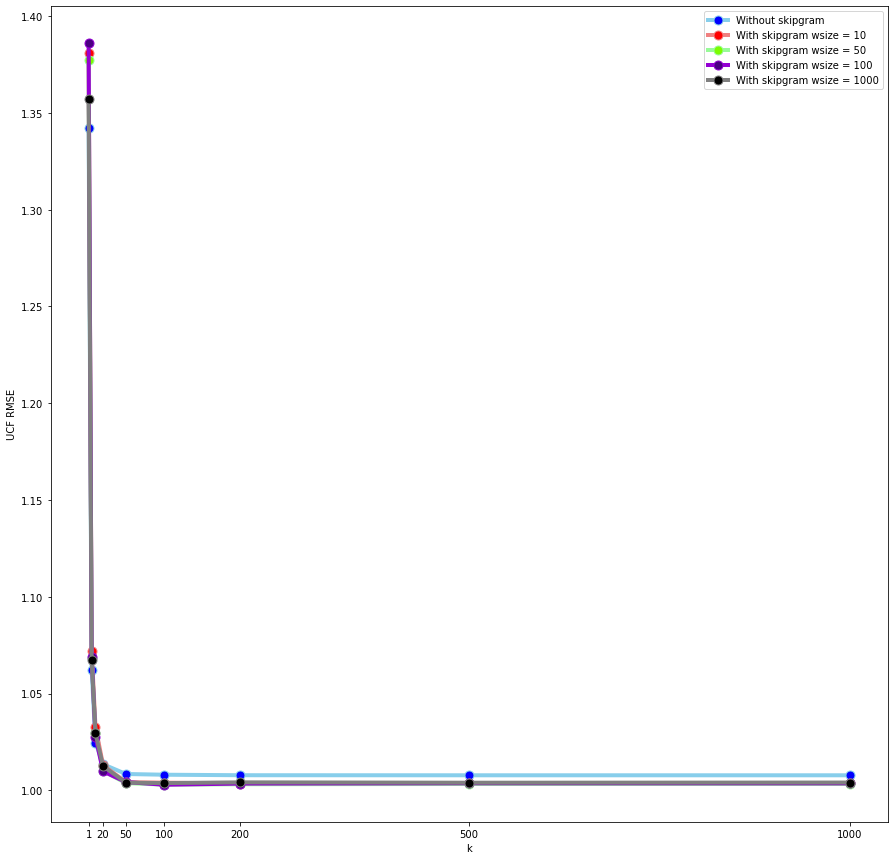

In [116]:
import matplotlib.pyplot as plt
import pandas as pd

# dataframe
df = pd.DataFrame({'UCF_k_values': UCF_k_values,  'UCF_RMSE_without_skipgram': UCF_RMSE_without_skipgram,
                  'UCF_RMSE_window_size_10': UCF_RMSE_window_size_10, 'UCF_RMSE_window_size_50': UCF_RMSE_window_size_50, 'UCF_RMSE_window_size_100': UCF_RMSE_window_size_100, 'UCF_RMSE_window_size_1000': UCF_RMSE_window_size_1000})
 
# multiple line plot
plt.figure(figsize = (15,15))
plt.ylabel('UCF RMSE')
plt.xlabel('k')
plt.xticks([1, 20, 50, 100, 200, 500, 1000])
plt.plot( 'UCF_k_values', 'UCF_RMSE_without_skipgram', data=df, marker='o', markerfacecolor='blue', markersize=9, color='skyblue', linewidth=4, label='Without skipgram')
plt.plot( 'UCF_k_values', 'UCF_RMSE_window_size_10', data=df, marker='o', markerfacecolor='red', markersize=9, color='lightcoral', linewidth=4, label='With skipgram wsize = 10')
plt.plot( 'UCF_k_values', 'UCF_RMSE_window_size_50', data=df, marker='o', markerfacecolor='lawngreen', markersize=9, color='palegreen', linewidth=4, label='With skipgram wsize = 50')
plt.plot( 'UCF_k_values', 'UCF_RMSE_window_size_100', data=df, marker='o', markerfacecolor='indigo', markersize=9, color='darkviolet', linewidth=4, label='With skipgram wsize = 100')
plt.plot( 'UCF_k_values', 'UCF_RMSE_window_size_1000', data=df, marker='o', markerfacecolor='black', markersize=9, color='gray', linewidth=4, label='With skipgram wsize = 1000')
plt.legend()